

# Loan Default Probability Predictor


## 1. Load dataset

**Import the libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pickle import dump
from pickle import load

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
import warnings
warnings.filterwarnings('ignore')

**Read in the data** 

In [171]:
# Read the large CSV file (this might take a minute or two)
#df = pd.read_csv('data/loan_data.csv')

# Save the DataFrame to a pickle file
#df.to_pickle('data/loan_data_pickle.pkl')

# Read the DataFrame from a pickle file (this takes a few seconds)
df = pd.read_pickle('data/loan_data_pickle.pkl')

In [3]:
# make sure nothing's being truncated
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [114]:
# Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [74]:
print('dataset dimension: ',df.shape)
df.head()

dataset dimension:  (1646801, 150)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,38098114,NaN,15000.0,15000.0,15000.0,60 months,12.39,336.64,C,C1,MANAGEMENT,10+ years,RENT,78000.0,Source Verified,Dec-2014,Fully Paid,n,NaN,debt_consolidation,Debt consolidation,235xx,VA,12.03,0.0,Aug-1994,750.0,754.0,0.0,NaN,NaN,6.0,0.0,138008.0,29.0,17.0,w,0.00,0.00,17392.37,17392.37,15000.00,2392.37,0.0,0.00,0.0000,Jun-2016,12017.81,NaN,Nov-2017,684.0,680.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,149140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184500.0,NaN,NaN,NaN,5.0,29828.0,9525.0,4.7,0.0,0.0,103.0,244.0,1.0,1.0,0.0,47.0,NaN,NaN,NaN,0.0,1.0,4.0,1.0,2.0,8.0,5.0,9.0,4.0,6.0,0.0,0.0,0.0,4.0,100.0,0.0,0.0,0.0,196500.0,149140.0,10000.0,12000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,36805548,NaN,10400.0,10400.0,10400.0,36 months,6.99,321.08,A,A3,Truck Driver Delivery Personel,8 years,MORTGAGE,58000.0,Not Verified,Dec-2014,Charged Off,n,NaN,credit_card,Credit card refinancing,937xx,CA,14.92,0.0,Sep-1989,710.0,714.0,2.0,42.0,NaN,17.0,0.0,6133.0,31.6,36.0,w,0.00,0.00,6611.69,6611.69,5217.75,872.67,0.0,521.27,93.8286,Aug-2016,321.08,NaN,Feb-2017,564.0,560.0,0.0,59.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,162110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19400.0,NaN,NaN,NaN,7.0,9536.0,7599.0,41.5,0.0,0.0,76.0,290.0,1.0,1.0,1.0,5.0,42.0,1.0,42.0,4.0,6.0,9.0,7.0,18.0,2.0,14.0,32.0,9.0,17.0,0.0,0.0,0.0,4.0,83.3,14.3,0.0,0.0,179407.0,15030.0,13000.0,11325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [160]:
print('dataset columns: ',df.columns)

dataset columns:  Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
      

## 2. EDA + Data Preparation pt.1 -- Target variable

In [4]:
# We're going to try to predict the loan_status. Let's take a closer look at this variable.
df['loan_status'].value_counts(dropna=False)

loan_status
Current                                                788950
Fully Paid                                             646902
Charged Off                                            168084
Late (31-120 days)                                      23763
In Grace Period                                         10474
Late (16-30 days)                                        5786
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Default                                                    70
NaN                                                        23
Name: count, dtype: int64

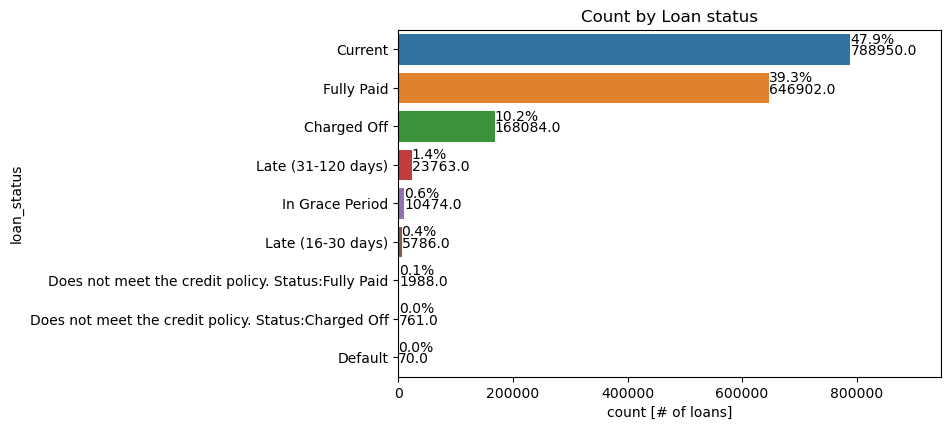

In [172]:
loan_status_order = df['loan_status'].value_counts().index

plt.figure(figsize=(7,4.5))
ax = sns.countplot(y='loan_status', data=df, order=loan_status_order)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_width()/len(df['loan_status'])), (p.get_width()+1, (p.get_y() + p.get_height()/2)-0.15))
    ax.annotate(f'{p.get_width()}', (p.get_width()+1, (p.get_y() + p.get_height()/2)+0.15))
ax.set_xlim(0, df['loan_status'].value_counts().max() * 1.2)
plt.title("Count by Loan status")
plt.xlabel('count [# of loans]')
plt.show()

We're only going to look at completed loans that are either "Fully Paid" or "Charged Off"/"Default". This means, we'll only keep the rows where loan_status is one of "Fully Paid", "Charged Off", or "Default".

A charge-off is a debt that a creditor has given up trying to collect on after you’ve missed payments for several months. The predicted variable takes value 1 in case of charge-off or default and 0 otherwise (fully paid).

In [173]:
df = df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]

# Prepare our target variable by adding a 'defaulted' column
df['defaulted'] = (df['loan_status'].isin(['Charged Off', 'Default'])).apply(np.float64)
df.drop('loan_status', axis=1, inplace=True)

print('dataset dimension: ',df.shape)

dataset dimension:  (815056, 150)


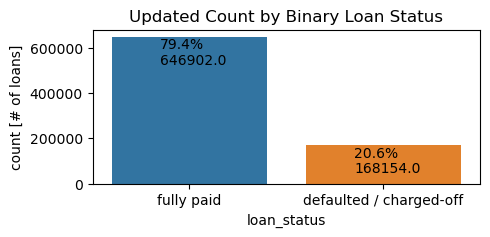

In [178]:
plt.figure(figsize=(5,2))

ax = sns.countplot(x='defaulted', data=df)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(df['defaulted'])), (p.get_x()+0.25, p.get_height()-50000))
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.25, p.get_height()-120000))

plt.title("Updated Count by Binary Loan Status")
plt.xlabel("loan_status")
plt.ylabel('count [# of loans]')
plt.xticks([0,1],["fully paid", "defaulted / charged-off"])
plt.show()

We see that about 80% of the loans are fully paid and about 20% have charged off / defaulted, giving us a **somewhat** unbalanced classification problem.


## 3. EDA + Data Preparation pt.2 -- Feature selection

**3.1 Missing Values in features**

In [179]:
perc_missing_per_ftr = df.isnull().sum(axis=0)*100/df.shape[0]
perc_data_has_missing = sum(df.isnull().sum(axis=1)!=0)*100/df.shape[0]

print('fraction of missing values features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

print('\n\n data types of the features with missing values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)

print('\n\n percentage of data with missing values:',perc_data_has_missing) # returning 100 -- meaning that all datapoints contain some missing values in features

fraction of missing values features:
member_id                                     100.000000
emp_title                                       5.959591
emp_length                                      5.184306
desc                                           85.310089
title                                           0.971835
dti                                             0.004417
inq_last_6mths                                  0.000123
mths_since_last_delinq                         51.187035
mths_since_last_record                         83.539781
revol_util                                      0.060119
last_pymnt_d                                    0.180233
next_pymnt_d                                   99.991412
last_credit_pull_d                              0.004785
collections_12_mths_ex_med                      0.006871
mths_since_last_major_derog                    74.795351
annual_inc_joint                               99.535983
dti_joint                                      99.5

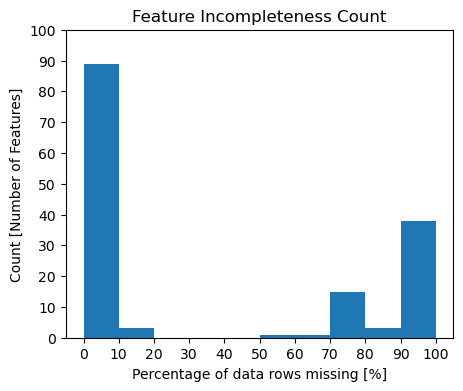

In [182]:
perc_missing_per_ftr = perc_missing_per_ftr.sort_values(ascending=False)

plt.figure(figsize=(5,4))
perc_missing_per_ftr.plot.hist(bins=10)
plt.title('Feature Incompleteness Count')
plt.xlabel('Percentage of data rows missing [%]')
plt.ylabel('Count [Number of Features]')
plt.xticks(np.arange(0, 105, 10))
plt.yticks(np.arange(0, 110, 10));

In [133]:
small_frac_missing_ftr = sorted(list(perc_missing_per_ftr[perc_missing_per_ftr < 20].index))
mid_frac_missing_ftr = sorted(list(perc_missing_per_ftr[(perc_missing_per_ftr >= 20) & (perc_missing_per_ftr <= 50)].index))
large_frac_missing_ftr = sorted(list(perc_missing_per_ftr[perc_missing_per_ftr > 50].index))
print("Features with < 20%   missing data : ", len(small_frac_missing_ftr),' i.e.', np.around(len(small_frac_missing_ftr) / 150 *100 ,2) ,'% of total features')
print("Features with 20%-50% missing data : ", len(mid_frac_missing_ftr), '  i.e.', np.around(len(mid_frac_missing_ftr) / 150 *100 ,2) ,'% of total features')
print("Features with > 50%   missing data : ", len(large_frac_missing_ftr),' i.e.', np.around(len(large_frac_missing_ftr) / 150 *100 ,2) ,'% of total features')

Features with < 20%   missing data :  92  i.e. 61.33 % of total features
Features with 20%-50% missing data :  0   i.e. 0.0 % of total features
Features with > 50%   missing data :  58  i.e. 38.67 % of total features


Here we see that about 60% features have <20% missing data, and the rest 40% have >50% missing data. Since we have a relatively large dataset, we'll still be able to keep the diversity of our dataset as well as many useful information needed in our classification task. Hence, we can eliminate those features with a large fraction of missing values.  

**3.2 Select Features**

Since we have 150 features here, in order to save computing power, we'll only keep the most relevant features to feed into our ML model. Features will be selected based on the following criteria:
- Eliminate features with > 20% missing values.
- Eliminate features that are not available to investors when making investment decisions.
- Eliminate features with low correlation with the target variable "defaulted", and one of the features fully correlated with each other.

**3.2.1 eliminate features with >20% missing values**

Most of these removed features include the term 'joint' (e.g., dti_joint), indicating that we are primarily removing features associated with loans that have co-borrowers. However, we are retaining features related to single borrowers. This is actually beneficial for us, ensuring that our processed dataset remains i.i.d. (independently and identically distributed).

Another common theme among the removed features is a shared 'heading' (e.g., hardship_xxx). This means that we are omitting only certain features describing a particular attribute, while still preserving the rest, thereby retaining the essential information we require.

In [134]:
drop_list = sorted(list(perc_missing_per_ftr[perc_missing_per_ftr > 20].index))
print(drop_list)
print('\n\n dropped number of features: ',len(drop_list))

df.drop(labels=drop_list, axis=1, inplace=True)
print('\n\n dataset dimension: ',df.shape)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

**3.2.2 eliminate features that are not available to investors when making investment decisions**

There's no better way to do this rather than going through the feature description and manually deciding which features would have been available to potential investors before an investment decision was made. 

In [135]:
# current feature list
print('# features: ',len(df.columns))
print('features sorted in alphabetical order: ',sorted(df.columns))

# features decided to keep:
keep_list = ['acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'defaulted', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'last_pymnt_amnt', 'loan_amnt', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'num_actv_rev_tl', 'open_acc', 'out_prncp', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'total_pymnt', 'total_rec_int', 'verification_status', 'zip_code']
print('\n\n # features kept: ',len(keep_list))

# drop the other features
drop_list = [col for col in df.columns if col not in keep_list]
df.drop(labels=drop_list, axis=1, inplace=True)
print('\n\n dataset dimension: ',df.shape)

# features:  92
features sorted in alphabetical order:  ['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'defaulted', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_re

**3.2.3 eliminate features with low correlation with the target variable "defaulted", and one of the features fullt correlated with each other.**

In [136]:
# calculate the correlation
float_features = df.select_dtypes(include=['float64'])
correlation = float_features.corr()

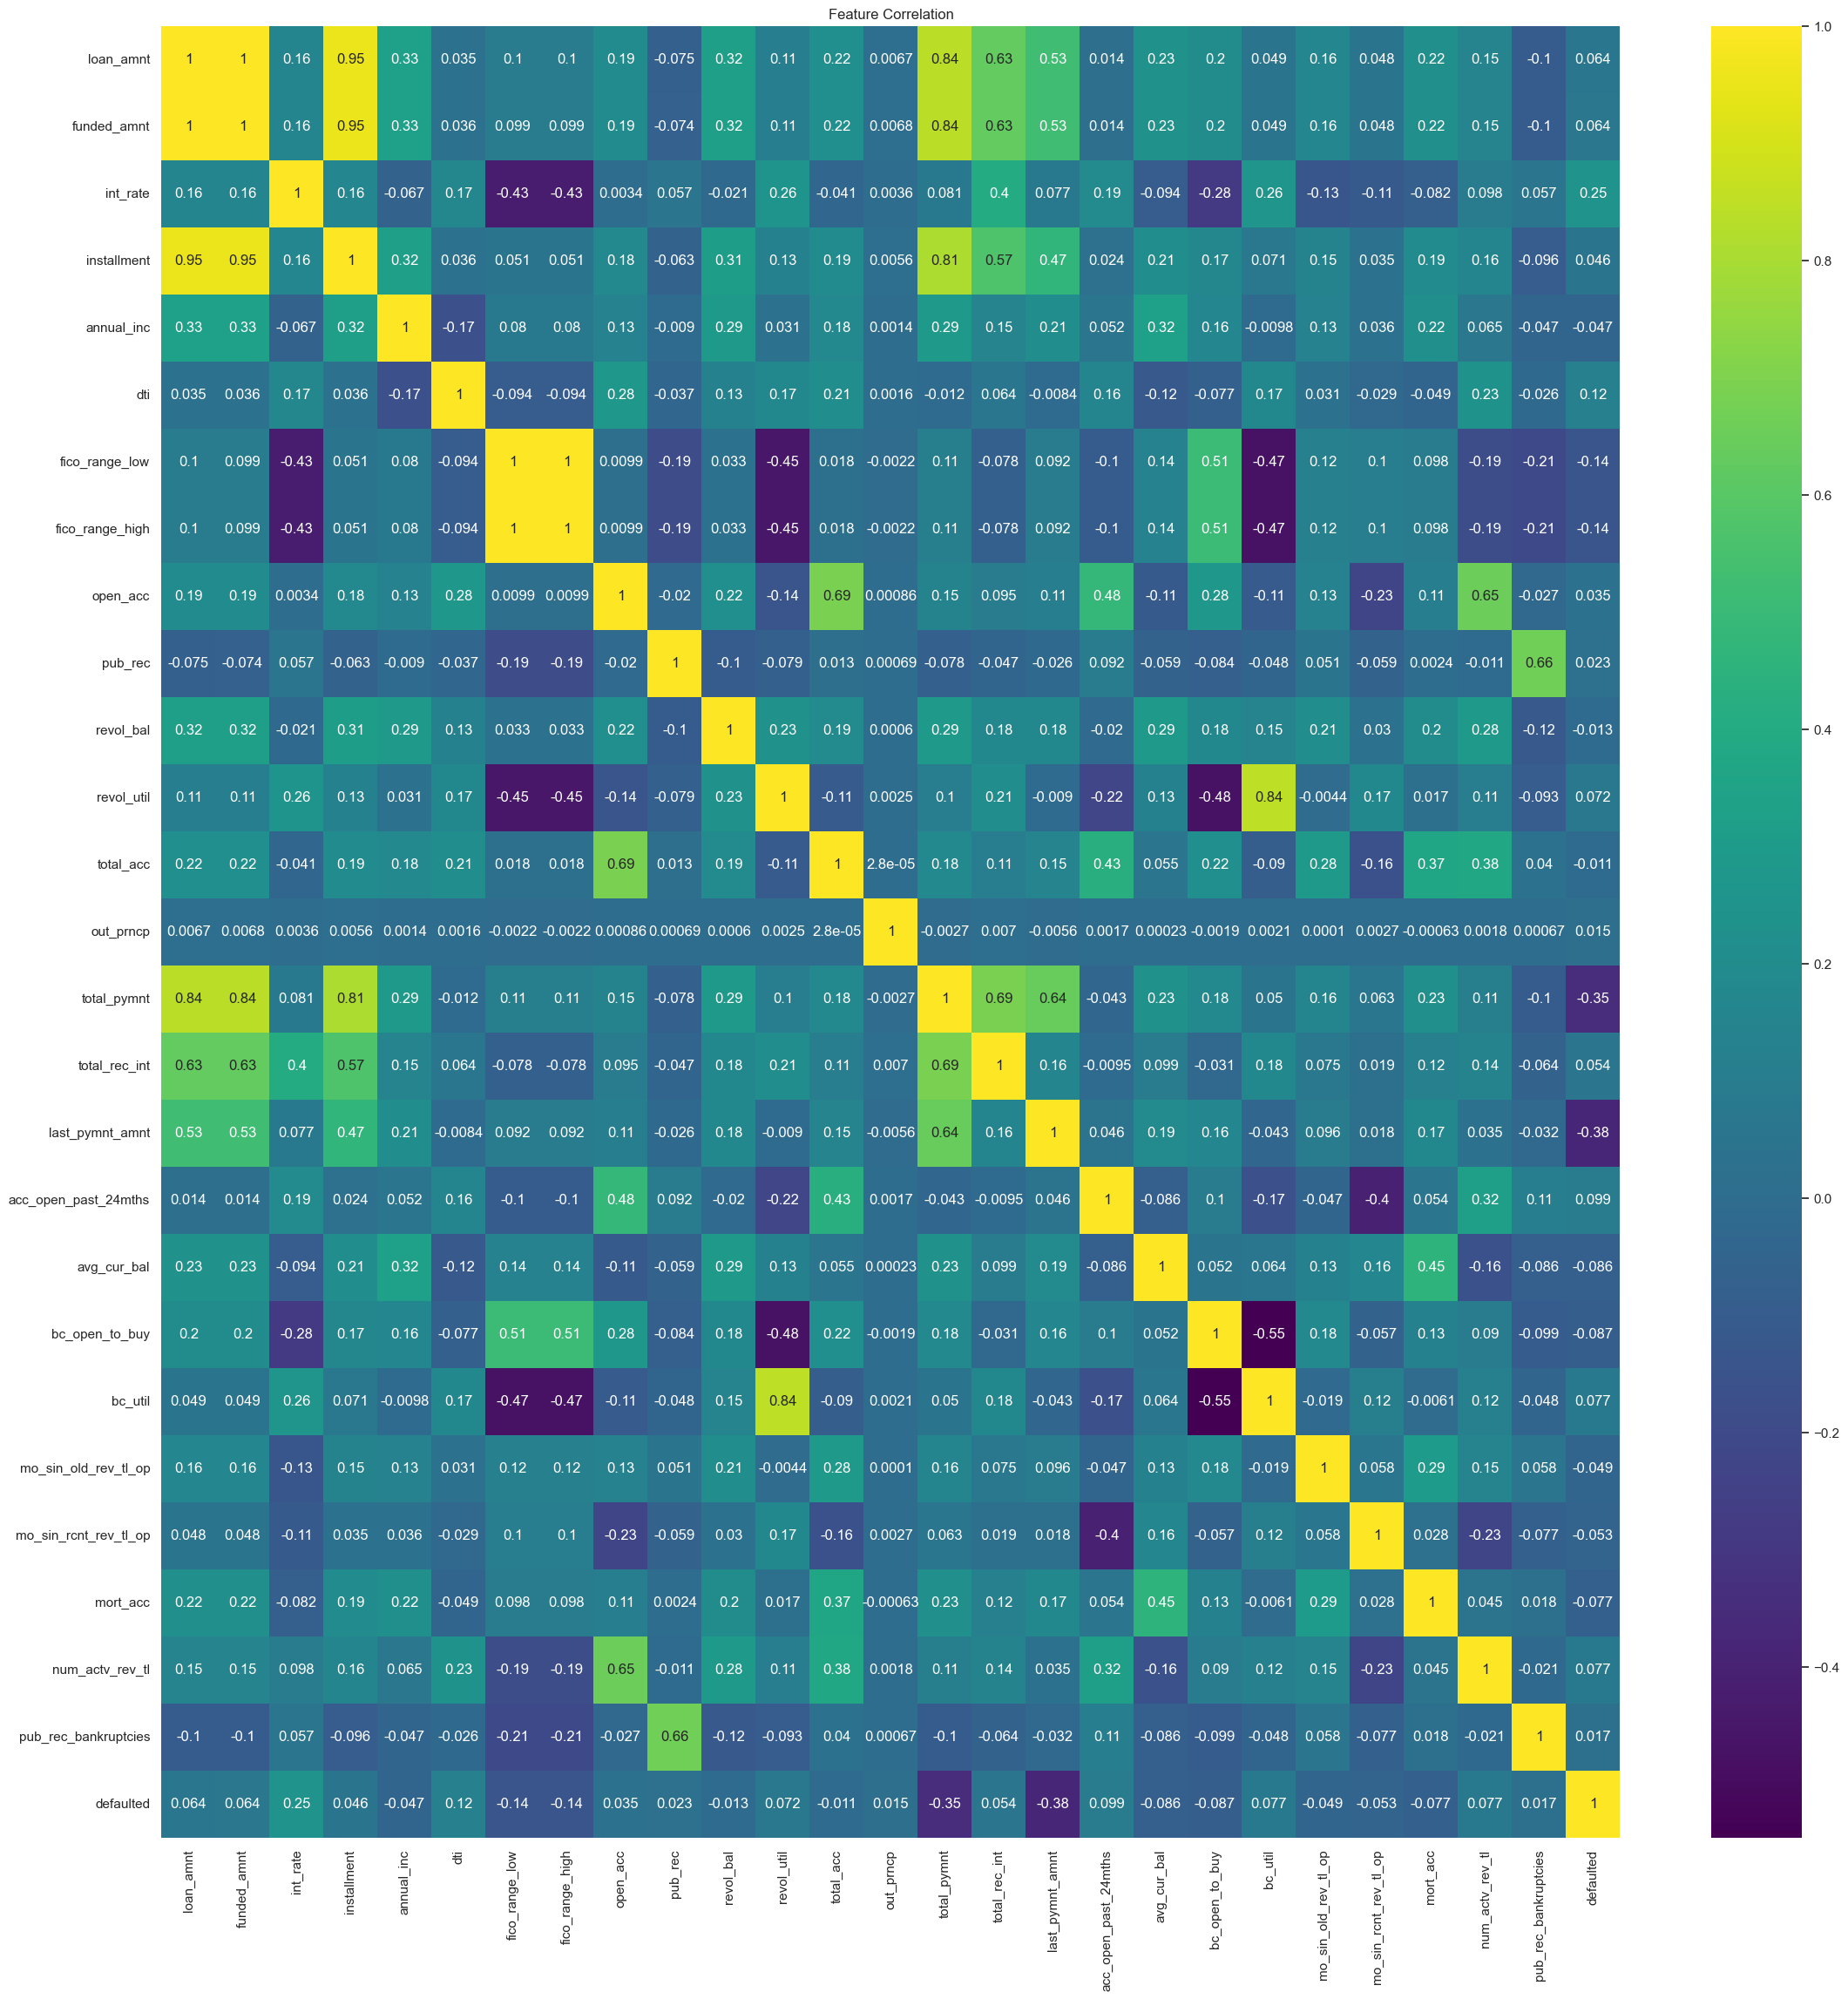

In [83]:
plt.figure(figsize=(27,27))
sns.heatmap(correlation, annot=True, cmap='viridis')
plt.title('Feature Correlation');

We see that some features are fully correlated with each other, so we need to remove one in each pair to reduce the risk of overfitting and save computational resources.

- loan_amnt, funded_amnt: remove funded_amnt
- fico_range_high and fico_range_low: create a new feature averaging the two instead of keeping both

In [137]:
df.drop(['funded_amnt'], axis=1, inplace=True)

df['fico_score'] = 0.5*df['fico_range_low'] + 0.5*df['fico_range_high']
df.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

print('dataset dimension: ',df.shape)

dataset dimension:  (815056, 40)


In [85]:
# recalculate the correlation
float_features = df.select_dtypes(include=['float64'])
correlation = float_features.corr()

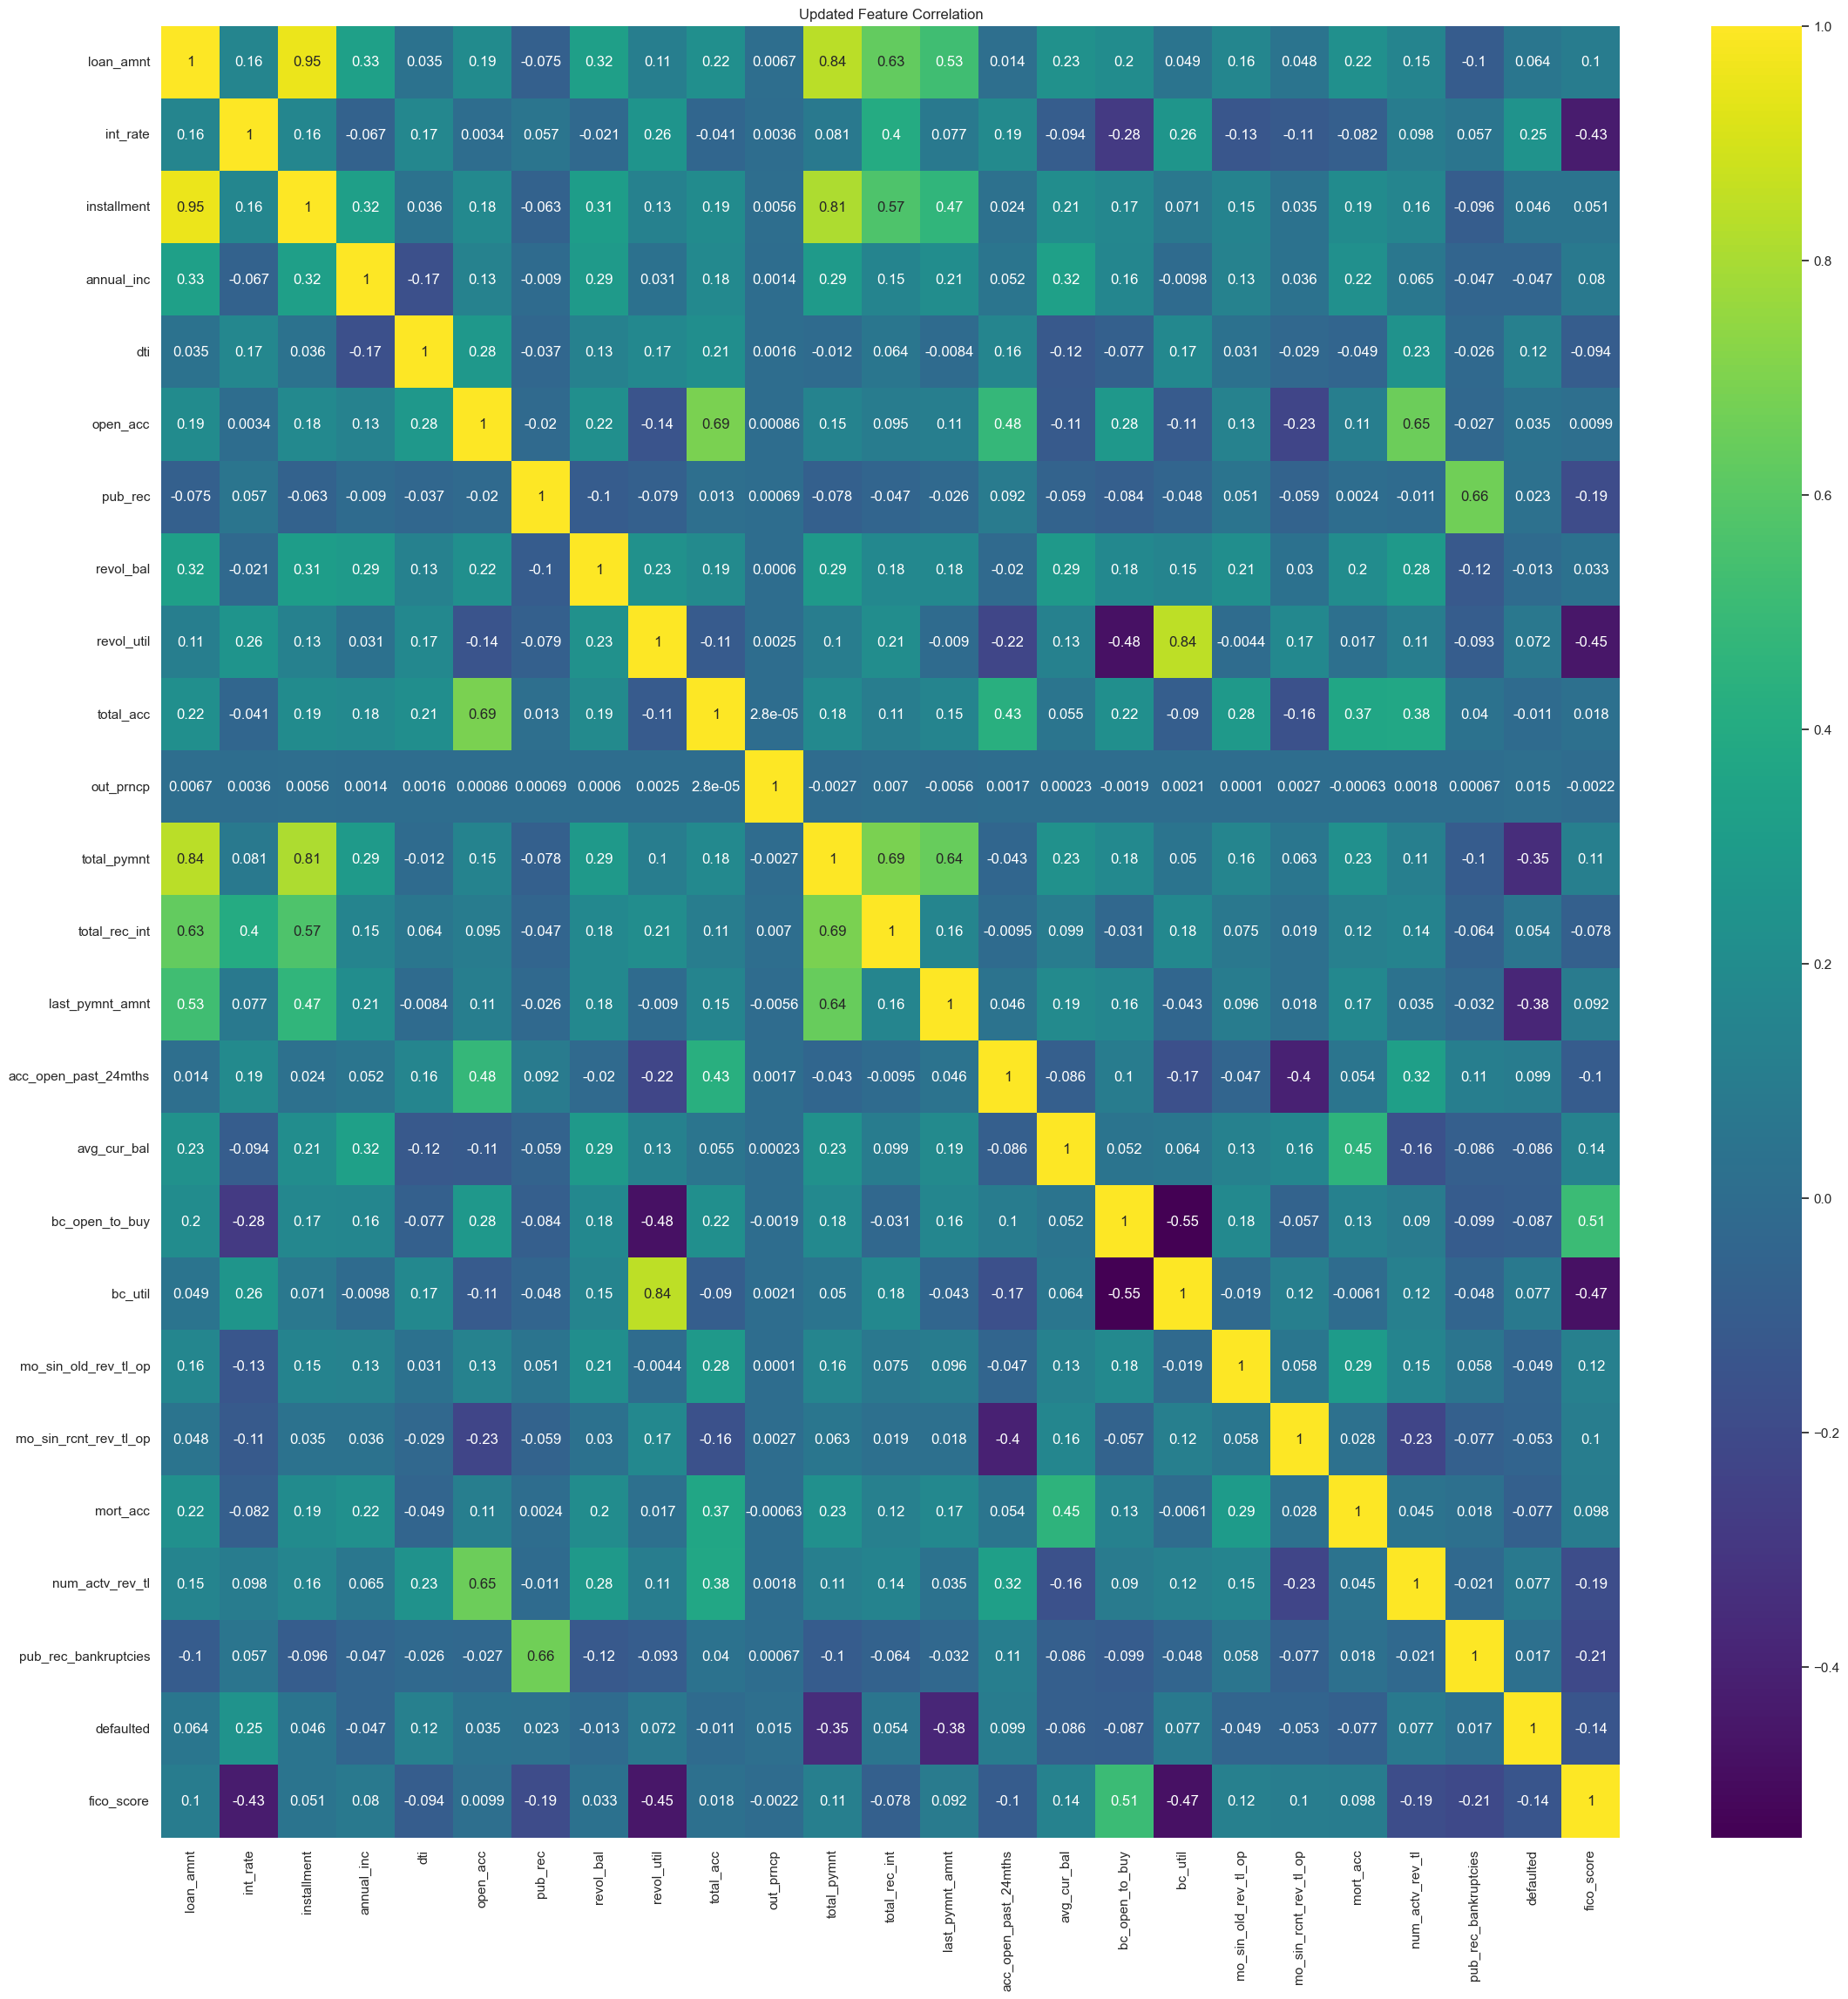

In [86]:
plt.figure(figsize=(27,27))
sns.heatmap(correlation, annot=True, cmap='viridis')
plt.title('Updated Feature Correlation');

In [139]:
correlation_defaulted = abs(correlation['defaulted']).sort_values(ascending=False)
print(correlation_defaulted)

defaulted                1.000000
last_pymnt_amnt          0.381411
total_pymnt              0.350998
int_rate                 0.247824
fico_range_low           0.139471
fico_range_high          0.139470
dti                      0.123057
acc_open_past_24mths     0.099007
bc_open_to_buy           0.086927
avg_cur_bal              0.085786
num_actv_rev_tl          0.077226
bc_util                  0.077168
mort_acc                 0.077101
revol_util               0.072213
funded_amnt              0.064280
loan_amnt                0.064161
total_rec_int            0.053620
mo_sin_rcnt_rev_tl_op    0.053411
mo_sin_old_rev_tl_op     0.048513
annual_inc               0.046680
installment              0.046310
open_acc                 0.034675
pub_rec                  0.023115
pub_rec_bankruptcies     0.017334
out_prncp                0.014772
revol_bal                0.013156
total_acc                0.011180
Name: defaulted, dtype: float64


In [140]:
# we decide to drop the last few features with a correlation value <0.015
drop_list_corr = sorted(list(correlation_defaulted[correlation_defaulted < 0.015].index))
print(drop_list_corr)

df.drop(labels=drop_list_corr, axis=1, inplace=True)
print('dataset dimension: ',df.shape)

['out_prncp', 'revol_bal', 'total_acc']
dataset dimension:  (815056, 37)


In [143]:
# % feature with missing value in updated feature list 

perc_missing_per_ftr = df.isnull().sum(axis=0)*100/df.shape[0]
perc_data_has_missing = sum(df.isnull().sum(axis=1)!=0)*100/df.shape[0]

print('percentage of missing values features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

print('\n\n data types of the features with missing values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)

print('\n\n percentage of data with missing values:',perc_data_has_missing)

percentage of missing values features:
emp_title                5.959591
emp_length               5.184306
title                    0.971835
dti                      0.004417
revol_util               0.060119
acc_open_past_24mths     5.800951
avg_cur_bal              8.286424
bc_open_to_buy           6.769842
bc_util                  6.829837
mo_sin_old_rev_tl_op     8.285075
mo_sin_rcnt_rev_tl_op    8.285075
mort_acc                 5.800951
num_actv_rev_tl          8.284952
pub_rec_bankruptcies     0.085516
dtype: float64


 data types of the features with missing values:
emp_title                 object
emp_length                object
title                     object
dti                      float64
revol_util               float64
acc_open_past_24mths     float64
avg_cur_bal              float64
bc_open_to_buy           float64
bc_util                  float64
mo_sin_old_rev_tl_op     float64
mo_sin_rcnt_rev_tl_op    float64
mort_acc                 float64
num_actv_rev_tl        

In [183]:
# Save the DataFrame to a pickle file so that we can directly load from here nexttime
#df.to_pickle('data/selected_loan_data_pickle.pkl')

df = pd.read_pickle('data/selected_loan_data_pickle.pkl')
print('dataset dimension: ',df.shape)

dataset dimension:  (815056, 37)


## 4. EDA + Data Preparation pt.3 -- Feature Format Cleaning

**4.1 Categorical & Ordinal Features**

In [94]:
categorical_cols = df.columns[df.dtypes==object].tolist()
print(categorical_cols)

['id', 'term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'application_type']


In [95]:
df[categorical_cols].describe()

,id,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,application_type
count,815056,815056,815056,815056,766482,772801,815056,815056,815056,807135,815056,815056,815056,815056,815056
unique,815056,2,7,35,280488,11,6,3,14,60297,925,51,712,2,2
top,38098114,36 months,B,B3,Teacher,10+ years,MORTGAGE,Source Verified,debt_consolidation,Debt consolidation,945xx,CA,Aug-2001,f,Individual
freq,1,618505,235239,51312,11351,264889,406893,293928,481692,371912,9517,124211,6025,413693,811274


In [96]:
df[categorical_cols].head(5)

,id,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,application_type
0,38098114,60 months,C,C1,MANAGEMENT,10+ years,RENT,Source Verified,debt_consolidation,Debt consolidation,235xx,VA,Aug-1994,w,Individual
1,36805548,36 months,A,A3,Truck Driver Delivery Personel,8 years,MORTGAGE,Not Verified,credit_card,Credit card refinancing,937xx,CA,Sep-1989,w,Individual
2,37842129,60 months,D,D1,Programming Analysis Supervisor,6 years,RENT,Source Verified,credit_card,Credit card refinancing,658xx,MO,Aug-2003,w,Individual
4,37662224,36 months,C,C3,Technical Specialist,< 1 year,RENT,Source Verified,debt_consolidation,Debt consolidation,850xx,AZ,Aug-2002,f,Individual
5,37822187,36 months,C,C3,Admin Specialist,10+ years,RENT,Source Verified,debt_consolidation,Debt consolidation,077xx,NJ,Nov-1992,f,Individual


**4.1.1 Categorical Feature Selection**

In [97]:
df[['id','emp_title','title','zip_code']].describe()

,id,emp_title,title,zip_code
count,815056,766482,807135,815056
unique,815056,280488,60297,925
top,38098114,Teacher,Debt consolidation,945xx
freq,1,11351,371912,9517


We see that IDs are all unique and it's meant to be used as a identification metric for loans. This means each loan is independeng of each other, verifying i.i.d. of the dataset. This will not be useful in predicting loan default probabilities, so we could drop the ID column.

Also, there are too many unique categories for job titles of the borrower ('emp_title'), loan titles ('title'), and borrower zipcode (zip_code). They will create trouble when we later preprocess our categorical features. We could also go about dropping them.

In [184]:
df.drop(['id','emp_title','title','zip_code'], axis=1, inplace=True)

**4.1.2 Categorical & Ordinal Feature Format Cleaning**

- **"term" feature**
    - Feature description: "The number of payments on the loan. Values are in months and can be either 36 or 60."
    - We see from the description above that this feature has 2 unique categories and is not yet formated as an integer. We'll now correctly format this feature so that we can use it later in our ML model.


In [209]:
# clean term feature by removing "month" from the input and cast it to an integer
df['term'] = df['term'].apply(lambda s: np.int64(s.split()[0]))

term
 36 months    0.165771
 60 months    0.333878
Name: proportion, dtype: float64


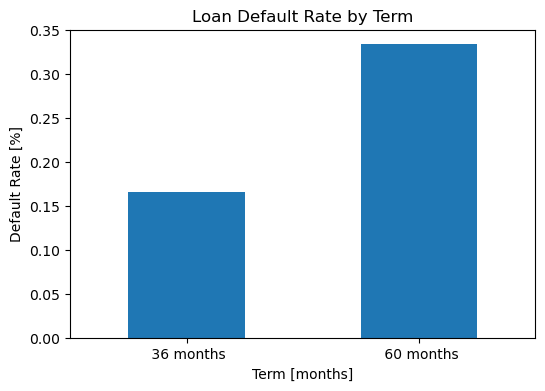

In [186]:
# Now let's do some visualization on this

term_groups = df.groupby('term')['defaulted'].value_counts(normalize=True).loc[:,1]
print(term_groups)

plt.figure(figsize=(6,4))
term_groups.plot.bar()
plt.title('Loan Default Rate by Term')
plt.xlabel('Term [months]')
plt.ylabel('Default Rate [%]')
plt.xticks(rotation=0)
plt.show()

We see that Loans with a five-year term (60 months) are more than twice as likely to charge-off / default as loans with a three-year term (36 months).

- **"earliest_cr_line" feature**
    - Feature description: "The month the borrower's earliest reported credit line was opened."
    - We see from the description above that this feature comes in MM-YYYY is not yet formated as a float. We'll now correctly format this feature and just keep the year, so that we can use it later in our ML model.


In [187]:
# clean feature by removing month from the input and cast it to a int
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda s: int(s[-4:]))

count    815056.000000
mean       1998.171036
std           7.385698
min        1944.000000
25%        1994.000000
50%        2000.000000
75%        2003.000000
max        2014.000000
Name: earliest_cr_line, dtype: float64


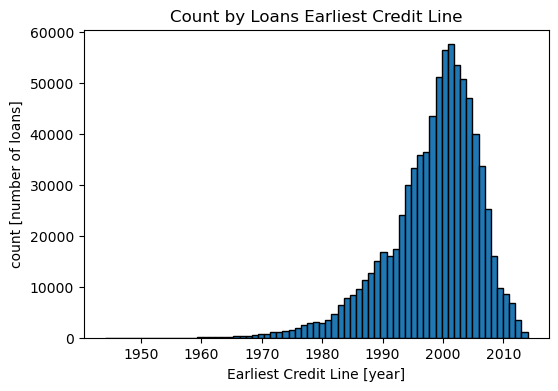

In [189]:
# Now let's do some visualization on this

print(df['earliest_cr_line'].describe())

plt.figure(figsize=(6,4))
df['earliest_cr_line'].plot.hist(bins = df['earliest_cr_line'].nunique(), edgecolor='black')   
plt.title('Count by Loans Earliest Credit Line')
plt.xlabel('Earliest Credit Line [year]') 
plt.ylabel('count [number of loans]')
plt.show()

After reformatting, this feature is now essentially a continuous feature.

- **"emp_length" feature**
    - Feature description: "Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. "

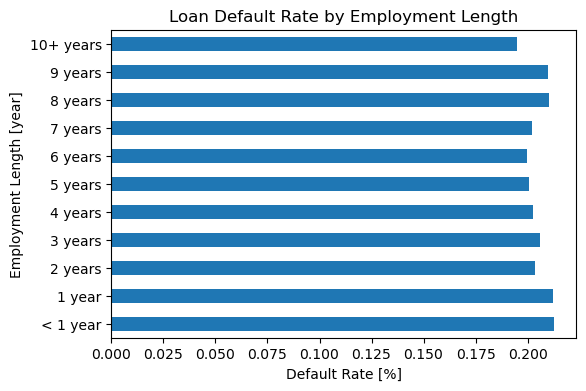

In [190]:
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
emp_len_group_default_rates = df.groupby('emp_length')['defaulted'].value_counts(normalize=True).loc[:,1]
plt.figure(figsize=(6,4))
emp_len_group_default_rates.reindex(order).plot.barh()
plt.title('Loan Default Rate by Employment Length')
plt.ylabel('Employment Length [year]')
plt.xlabel('Default Rate [%]')
plt.show()

We see that the the loan default rate does not appear to vary much with employment length on average, hence we can drop this feature.

In [191]:
df.drop(['emp_length'], axis=1, inplace=True)

**4.1.3 Continuous Feature Format Cleaning**

- **"annual_inc" feature**
    - Feature description: "The self-reported annual income provided by the borrower during registration."

In [106]:
df[['annual_inc']].describe()

,annual_inc
count,8.150560e+05
mean,7.523024e+04
std,6.524262e+04
min,0.000000e+00
25%,4.500000e+04
50%,6.500000e+04
75%,9.000000e+04
max,9.550000e+06


Annual income ranges from 0  to  9,550,000, with a median of $65,000. This feature has a very large range compared to other features in our dataset. Hence, we will do a log transformation to compensate for the large range here.

In [213]:
df['log_annual_inc'] = df['annual_inc'].apply(lambda x: np.log10(x+1))
df.drop('annual_inc', axis=1, inplace=True)

In [ ]:
# Dropping rows with missing values. Since this is a large dataset, we are still able to capture the nuances without these rows containing missing values

df_cleaned = df.dropna()
perc_missing_per_ftr = df_cleaned.isnull().sum(axis=0)*100/df_cleaned.shape[0]
perc_data_has_missing = sum(df_cleaned.isnull().sum(axis=1)!=0)*100/df_cleaned.shape[0]

print('percentage of data with missing values:',perc_data_has_missing)

**4.1.4 Filtering out rows with missing Value**

In [8]:
print(df.shape)
perc_missing_per_ftr = df.isnull().sum(axis=0)*100/df.shape[0]
perc_data_has_missing = sum(df.isnull().sum(axis=1)!=0)*100/df.shape[0]

print('percentage of data with missing values:',perc_data_has_missing)

(815056, 32)
percentage of data with missing values: 9.283411201193537


We see that about 9% of the rows contain missing values. To make sure that we are able to perform model selection on various ML techniques like Logistic Regression, KNN, Random Forest etc, we will drop these rows. Since this is a very large dataset, we are still able to capture the nuances of our dataset without these rows.

In [11]:
# Dropping rows with missing values. 
df = df.dropna()
perc_missing_per_ftr = df.isnull().sum(axis=0)*100/df.shape[0]
perc_data_has_missing = sum(df.isnull().sum(axis=1)!=0)*100/df.shape[0]

print(df.shape)
print('percentage of data with missing values:',perc_data_has_missing)

(739391, 32)
percentage of data with missing values: 0.0


In [12]:
# Save the DataFrame to a pickle file so that we can directly load from here next time
# df.to_pickle('data/cleaned_loan_data_pickle.pkl')

df = pd.read_pickle('data/cleaned_loan_data_pickle.pkl')
print('dataset dimension: ',df.shape)

dataset dimension:  (739391, 32)


## 5. EDA on Cleaned Dataset

**5.1 General patterns**

In [13]:
print('dataset dimension: ',df.shape)
df.head(10)

dataset dimension:  (739391, 32)


,loan_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,...,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,pub_rec_bankruptcies,defaulted,fico_score,log_annual_inc
0,15000.0,60,12.39,336.64,C,C1,RENT,Source Verified,debt_consolidation,VA,...,9525.0,4.7,244.0,1.0,0.0,4.0,0.0,0.0,752.0,4.892100
1,10400.0,36,6.99,321.08,A,A3,MORTGAGE,Not Verified,credit_card,CA,...,7599.0,41.5,290.0,1.0,1.0,9.0,0.0,1.0,712.0,4.763435
2,21425.0,60,15.59,516.36,D,D1,RENT,Source Verified,credit_card,MO,...,324.0,97.8,136.0,7.0,0.0,4.0,0.0,0.0,687.0,4.804827
4,7650.0,36,13.66,260.20,C,C3,RENT,Source Verified,debt_consolidation,AZ,...,332.0,93.2,148.0,8.0,0.0,4.0,0.0,1.0,687.0,4.698979
5,9600.0,36,13.66,326.53,C,C3,RENT,Source Verified,debt_consolidation,NJ,...,6494.0,69.2,265.0,23.0,0.0,7.0,0.0,0.0,682.0,4.838855
6,2500.0,36,11.99,83.03,B,B5,MORTGAGE,Source Verified,home_improvement,MN,...,1333.0,86.4,148.0,24.0,5.0,4.0,0.0,0.0,687.0,4.949395
7,16000.0,60,11.44,351.40,B,B4,OWN,Verified,debt_consolidation,VA,...,2559.0,72.2,133.0,17.0,2.0,3.0,0.0,0.0,702.0,5.040515
8,23325.0,36,14.31,800.71,C,C4,RENT,Source Verified,credit_card,WA,...,3977.0,89.0,194.0,15.0,6.0,5.0,0.0,1.0,667.0,4.857339
9,5250.0,36,11.44,172.98,B,B4,RENT,Not Verified,debt_consolidation,MD,...,12152.0,26.8,67.0,12.0,0.0,2.0,0.0,0.0,747.0,4.414990
10,10000.0,36,11.99,332.10,B,B5,RENT,Verified,debt_consolidation,MI,...,324.0,98.5,124.0,40.0,0.0,5.0,0.0,1.0,677.0,4.954247


In [14]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 739391 entries, 0 to 1646792
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   loan_amnt              739391 non-null  float64
 1   term                   739391 non-null  int64  
 2   int_rate               739391 non-null  float64
 3   installment            739391 non-null  float64
 4   grade                  739391 non-null  object 
 5   sub_grade              739391 non-null  object 
 6   home_ownership         739391 non-null  object 
 7   verification_status    739391 non-null  object 
 8   purpose                739391 non-null  object 
 9   addr_state             739391 non-null  object 
 10  dti                    739391 non-null  float64
 11  earliest_cr_line       739391 non-null  int64  
 12  open_acc               739391 non-null  float64
 13  pub_rec                739391 non-null  float64
 14  revol_util             739391 non-null  

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,739391.0,14552.614956,8527.645890,1000.000000,8000.000000,12350.000000,20000.000000,40000.000000
term,739391.0,41.810577,10.280622,36.000000,36.000000,36.000000,36.000000,60.000000
int_rate,739391.0,13.562791,4.652183,5.320000,10.150000,13.110000,16.290000,30.990000
installment,739391.0,444.528786,256.830270,4.930000,258.590000,384.090000,586.740000,1714.540000
dti,739391.0,18.193136,8.934558,-1.000000,11.920000,17.660000,24.050000,999.000000
earliest_cr_line,739391.0,1998.273532,7.430533,1944.000000,1995.000000,2000.000000,2003.000000,2014.000000
open_acc,739391.0,11.729698,5.364510,1.000000,8.000000,11.000000,14.000000,90.000000
pub_rec,739391.0,0.220142,0.605305,0.000000,0.000000,0.000000,0.000000,86.000000
revol_util,739391.0,53.122694,23.947491,0.000000,35.300000,53.700000,71.600000,366.600000
total_pymnt,739391.0,14559.395659,10063.426695,0.000000,6779.983834,12060.307256,20232.240003,61501.879669


In [16]:
duplicate = df.duplicated()
print('Number of duplicated rows: ',duplicate.sum())

Number of duplicated rows:  0


In [17]:
perc_missing_per_ftr = df.isnull().sum(axis=0)*100/df.shape[0]
perc_data_has_missing = sum(df.isnull().sum(axis=1)!=0)*100/df.shape[0]

print('percentage of missing values features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

print('\n\n data types of the features with missing values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)

print('\n\n percentage of data with missing values:',perc_data_has_missing)

percentage of missing values features:
Series([], dtype: float64)


 data types of the features with missing values:
Series([], dtype: object)


 percentage of data with missing values: 0.0


**5.2 Categorical & Ordinal Features**

In [18]:
categorical_cols = df.columns[df.dtypes==object].tolist()
categorical_cols.append('term')
print(categorical_cols)
df[categorical_cols].describe()

['grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type', 'term']


,term
count,739391.000000
mean,41.810577
std,10.280622
min,36.000000
25%,36.000000
50%,36.000000
75%,36.000000
max,60.000000


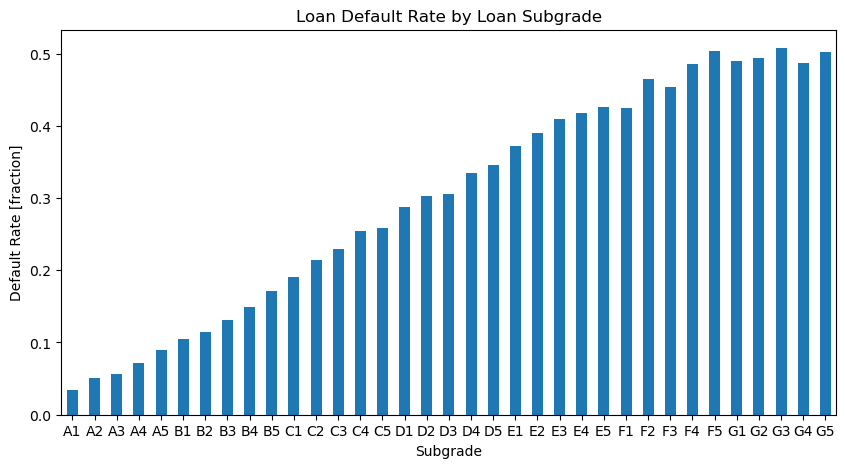

In [19]:
# subgrade

plt.figure(figsize=(10, 5))
subgrade_default_rates = df.groupby('sub_grade')['defaulted'].value_counts(normalize=True).loc[:,1]
subgrade_default_rates.plot.bar()
plt.title('Loan Default Rate by Loan Subgrade')
plt.xlabel('Subgrade')
plt.ylabel('Default Rate [fraction]')
plt.xticks(rotation=0)
plt.show()


There's a clear trend of higher probability of default / charged-off as the loan subgrade worsens.

defaulted          0.0    1.0
home_ownership               
ANY                 74     16
MORTGAGE        305348  67295
NONE                35      7
OTHER               36      8
OWN              59796  16809
RENT            218064  71903


 defaulted            0.0       1.0
home_ownership                    
ANY             0.822222  0.177778
MORTGAGE        0.819412  0.180588
NONE            0.833333  0.166667
OTHER           0.818182  0.181818
OWN             0.780576  0.219424
RENT            0.752030  0.247970


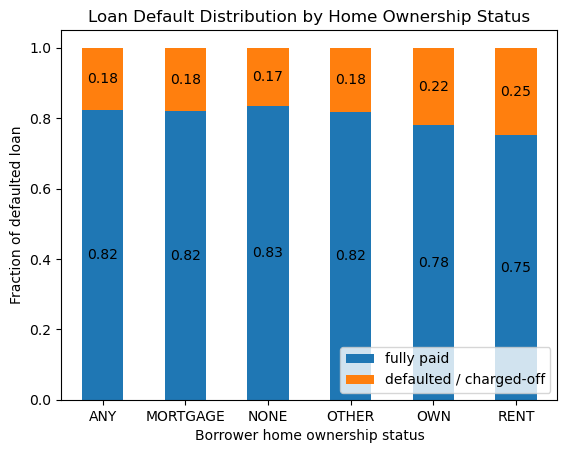

In [20]:
# home_ownership

count_matrix = df.groupby(['home_ownership', 'defaulted']).size().unstack()
print(count_matrix)

count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
print('\n\n', count_matrix_norm)

ax = count_matrix_norm.plot(kind='bar', stacked=True)

for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_y() + height / 2
        ax.text(x, y, f"{height:.2f}", ha='center', va='center')

plt.title('Loan Default Distribution by Home Ownership Status')
plt.ylabel('Fraction of defaulted loan')
plt.xlabel('Borrower home ownership status')
plt.xticks(rotation=0)
plt.legend(['fully paid', 'defaulted / charged-off'],loc=4)
plt.show()

There seems to be some difference in loan default rates by loan borrower's home ownership status. Renters and homeowners have a higher probability of defaulting, while those not owning a home have lower chance of defaulting. It's interesting to see that home owners have high default rate, as they are expected to have more stable financials.

verification_status
Not Verified       0.154920
Source Verified    0.224439
Verified           0.247021
Name: proportion, dtype: float64


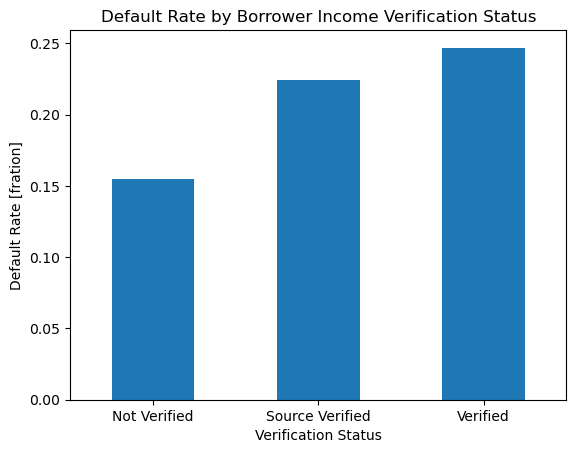

In [21]:
# verification_status

verification_status_default_rates = df.groupby('verification_status')['defaulted'].value_counts(normalize=True).loc[:,1]
print(verification_status_default_rates)

verification_status_default_rates.plot.bar()

plt.title('Default Rate by Borrower Income Verification Status')
plt.xlabel('Verification Status')
plt.ylabel('Default Rate [fration]')
plt.xticks(rotation=0)
plt.show()

We see that borrowers whose income was not verified by "Lending Club", surprisingly, have a lower default rate than those who have their income or income source verified.

In [22]:
# purpose
df.groupby('purpose')['defaulted'].value_counts(normalize=True).loc[:,1].sort_values()

purpose
wedding               0.150000
car                   0.161964
credit_card           0.182144
home_improvement      0.187765
major_purchase        0.199352
vacation              0.205470
debt_consolidation    0.221337
house                 0.222124
other                 0.225281
medical               0.239286
moving                0.255430
renewable_energy      0.260579
small_business        0.317686
Name: proportion, dtype: float64

In [23]:
# addr_state
df.groupby('addr_state')['defaulted'].value_counts(normalize=True).loc[:,1].sort_values()

addr_state
ME    0.136905
DC    0.139691
NH    0.143685
VT    0.146619
OR    0.152243
CO    0.159293
WA    0.165784
KS    0.174729
SC    0.174735
WI    0.177557
MT    0.180672
UT    0.181116
WY    0.187462
WV    0.188769
CT    0.189152
ID    0.192079
GA    0.193809
RI    0.197597
IL    0.199516
MA    0.200564
CA    0.201878
AZ    0.202692
AK    0.207135
TX    0.208100
HI    0.208259
MI    0.212384
DE    0.213654
MN    0.215389
VA    0.215661
NC    0.219219
MD    0.221082
NJ    0.221664
KY    0.221672
PA    0.222905
MO    0.223487
FL    0.225976
IN    0.228620
NM    0.229221
TN    0.229725
OH    0.232329
SD    0.232528
NY    0.235626
NV    0.236707
ND    0.237937
LA    0.246734
AR    0.252038
AL    0.252948
OK    0.255650
NE    0.266906
MS    0.276649
Name: proportion, dtype: float64

**5.3 Continuous Features**

In [24]:
continuous_cols = df.columns[df.dtypes!=object].tolist()
continuous_cols.remove('term')
print(continuous_cols)
df[continuous_cols].describe()

['loan_amnt', 'int_rate', 'installment', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_util', 'total_pymnt', 'total_rec_int', 'last_pymnt_amnt', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'num_actv_rev_tl', 'pub_rec_bankruptcies', 'defaulted', 'fico_score', 'log_annual_inc']


,loan_amnt,int_rate,installment,dti,earliest_cr_line,open_acc,pub_rec,revol_util,total_pymnt,total_rec_int,...,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,pub_rec_bankruptcies,defaulted,fico_score,log_annual_inc
count,739391.000000,739391.000000,739391.000000,739391.000000,739391.000000,739391.000000,739391.000000,739391.000000,739391.000000,739391.000000,...,739391.000000,739391.000000,739391.000000,739391.000000,739391.000000,739391.000000,739391.000000,739391.000000,739391.000000,739391.000000
mean,14552.614956,13.562791,444.528786,18.193136,1998.273532,11.729698,0.220142,53.122694,14559.395659,2238.312713,...,9488.356765,61.499487,180.885729,12.588626,1.764777,5.694160,0.140635,0.211036,696.235106,4.815260
std,8527.645890,4.652183,256.830270,8.934558,7.430533,5.364510,0.605305,23.947491,10063.426695,2354.092101,...,14590.886843,27.860383,92.195996,15.447628,2.079288,3.210716,0.386445,0.408044,30.603318,0.228517
min,1000.000000,5.320000,4.930000,-1.000000,1944.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,662.000000,2.004321
25%,8000.000000,10.150000,258.590000,11.920000,1995.000000,8.000000,0.000000,35.300000,6779.983834,739.675000,...,1323.000000,40.700000,117.000000,4.000000,0.000000,3.000000,0.000000,0.000000,672.000000,4.662767
50%,12350.000000,13.110000,384.090000,17.660000,2000.000000,11.000000,0.000000,53.700000,12060.307256,1522.840000,...,4284.000000,65.200000,164.000000,8.000000,1.000000,5.000000,0.000000,0.000000,687.000000,4.812920
75%,20000.000000,16.290000,586.740000,24.050000,2003.000000,14.000000,0.000000,71.600000,20232.240003,2855.050000,...,11380.000000,85.900000,228.000000,15.000000,3.000000,7.000000,0.000000,0.000000,712.000000,4.954247
max,40000.000000,30.990000,1714.540000,999.000000,2014.000000,90.000000,86.000000,366.600000,61501.879669,26501.880000,...,559912.000000,339.600000,842.000000,372.000000,47.000000,57.000000,12.000000,1.000000,847.500000,6.980003


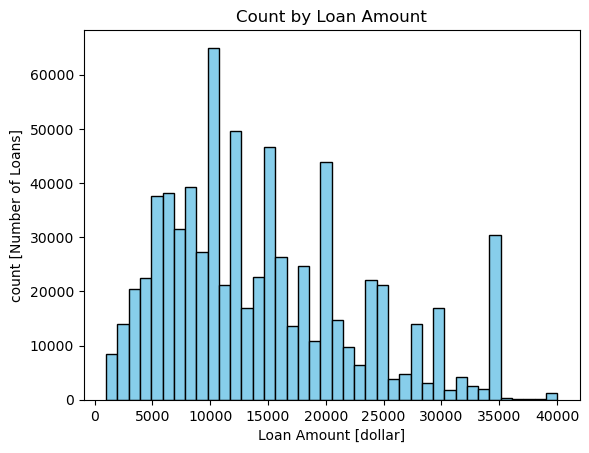

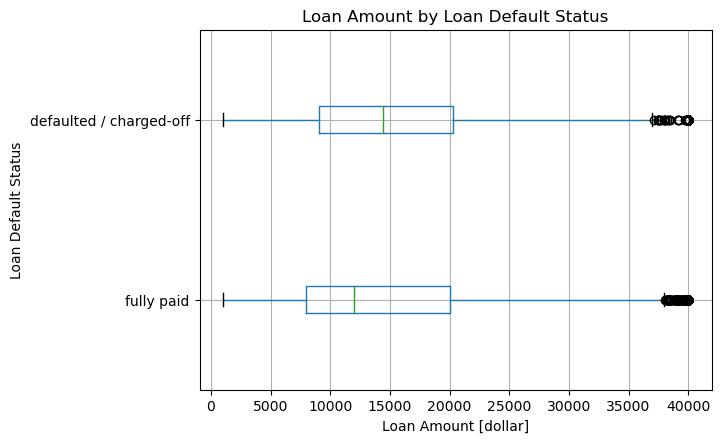

In [25]:
# loan amount

plt.hist(df['loan_amnt'],bins = 40,color='skyblue', edgecolor='black')   
plt.title('Count by Loan Amount')
plt.xlabel('Loan Amount [dollar]') 
plt.ylabel('count [Number of Loans]')
plt.show()

df[['loan_amnt','defaulted']].boxplot(by='defaulted', vert=False)
plt.xlabel('Loan Amount [dollar]')
plt.ylabel('Loan Default Status')
plt.yticks([1,2],['fully paid','defaulted / charged-off'])
plt.title('Loan Amount by Loan Default Status')
plt.suptitle('')
plt.show()

Defaulted loans tend to have higher loan amounts.

In [26]:
df.groupby('defaulted')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
defaulted,,,,,,,,
0.0,583353.0,14284.754471,8488.441555,1000.0,8000.0,12000.0,20000.0,40000.0
1.0,156038.0,15554.019854,8599.078808,1000.0,9025.0,14400.0,20250.0,40000.0


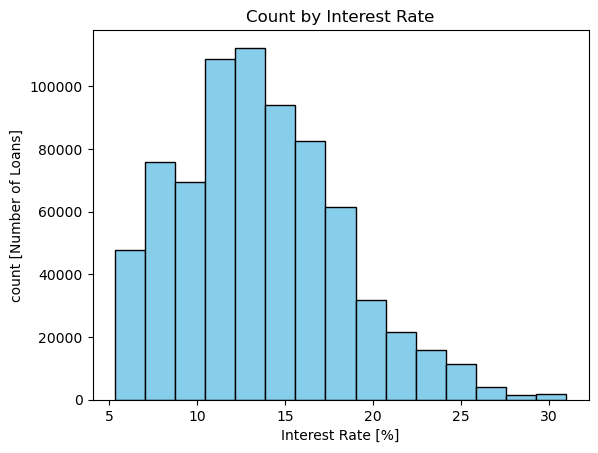

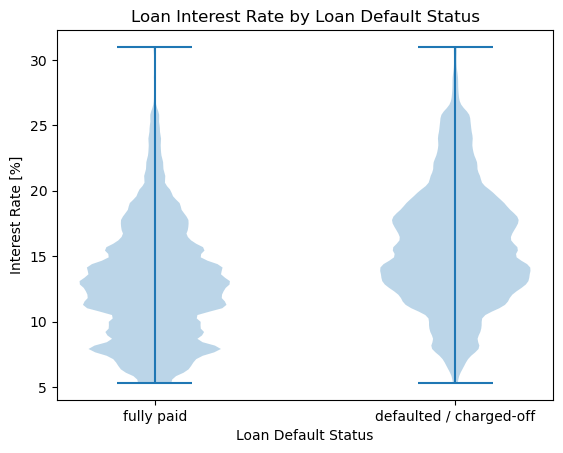

In [27]:
# interest rate

plt.hist(df['int_rate'],bins = 15,color='skyblue', edgecolor='black')   
plt.title('Count by Interest Rate')
plt.xlabel('Interest Rate [%]') 
plt.ylabel('count [Number of Loans]')
plt.show()


dataset = [df[df['defaulted']==0.0]['int_rate'].values,
           df[df['defaulted']==1.0]['int_rate'].values]
plt.violinplot(dataset=dataset)
plt.title('Loan Interest Rate by Loan Default Status')
plt.xticks([1,2],['fully paid','defaulted / charged-off'])
plt.xlabel('Loan Default Status')
plt.ylabel('Interest Rate [%]')
plt.show()

In [28]:
df['int_rate'].describe()

count    739391.000000
mean         13.562791
std           4.652183
min           5.320000
25%          10.150000
50%          13.110000
75%          16.290000
max          30.990000
Name: int_rate, dtype: float64

Defaulted loans tend to have much higher interest rates, and a loan's interest rate can range from 5.3% to up to 31%. 

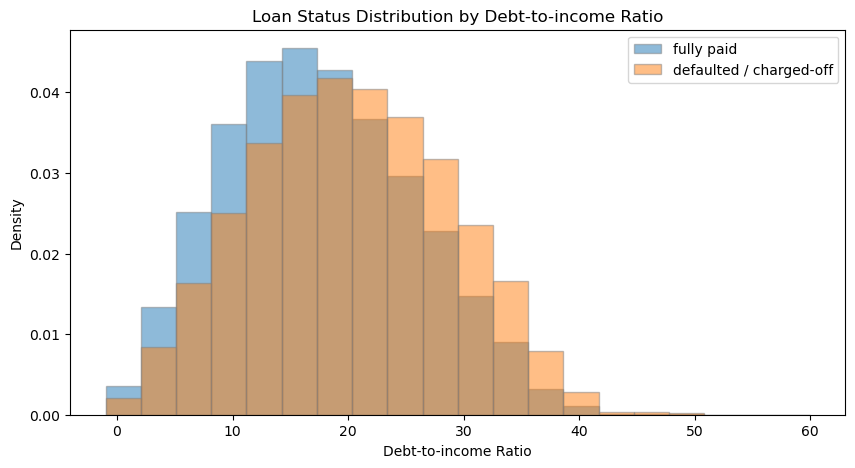

In [29]:
# dti
plt.figure(figsize=(10, 5))

categories = df['defaulted'].unique()
bin_range = (df['dti'].min(),60)

for c in categories:
    plt.hist(df[df['defaulted']==c]['dti'],alpha=0.5,label=c,range=bin_range,bins=20,edgecolor='grey',density=True)
plt.legend()
plt.ylabel('Density')
plt.xlabel('Debt-to-income Ratio')
plt.title('Loan Status Distribution by Debt-to-income Ratio')
plt.legend(['fully paid', 'defaulted / charged-off'])
plt.show()

Lower DTI indicaties that a smaller portion of the borrower's income is dedicated to debt payments and borrower has a good balance between income and debt.

Higher DTI shows that a larger portion of the borrower's income is committed to debt payments.This can be a warning sign that the borrower is overextended and might struggle to handle additional monthly payments or unforeseen financial hardships.

Here, distribution for borrowers of fully paid loan leans towards lower DTI, which is expected.


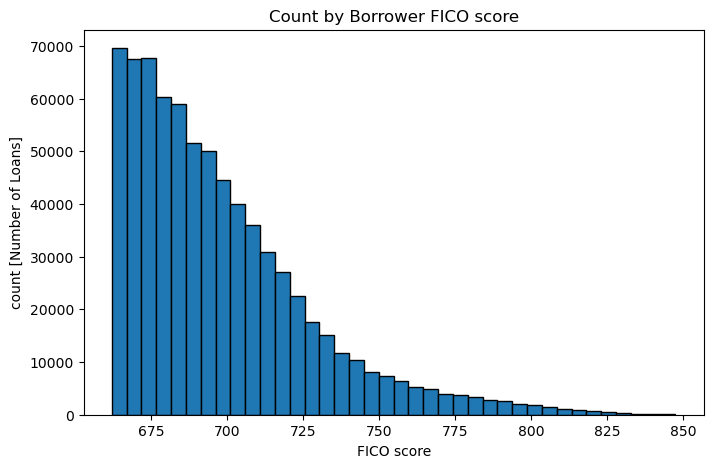

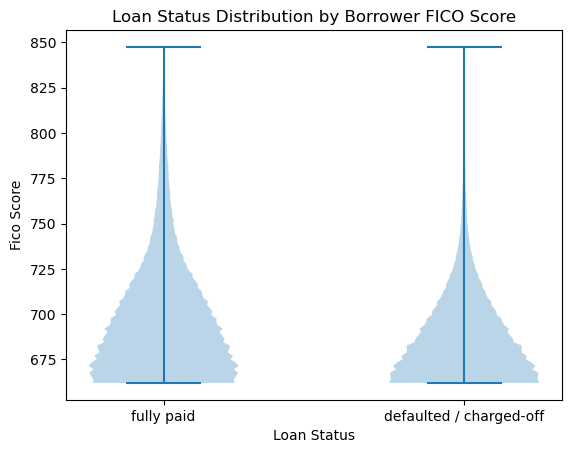

In [30]:
# fico score

plt.figure(figsize=(8, 5))

plt.hist(df['fico_score'],bins = df['fico_score'].nunique(), edgecolor='black')   
plt.title('Count by Borrower FICO score')
plt.xlabel('FICO score') 
plt.ylabel('count [Number of Loans]')
plt.show()


dataset = [df[df['defaulted']==0.0]['fico_score'].values,
           df[df['defaulted']==1.0]['fico_score'].values]
plt.violinplot(dataset=dataset)
plt.title('Loan Status Distribution by Borrower FICO Score')
plt.xticks([1,2],['fully paid','defaulted / charged-off'])
plt.xlabel('Loan Status')
plt.ylabel('Fico Score')
plt.show()

## 6. Preprocessing & Model Selection

**6.1 Splitting Dataset**

In [3]:
# Load cleaned dataset
df = pd.read_pickle('data/cleaned_loan_data_pickle.pkl')
print('dataset dimension: ',df.shape)

dataset dimension:  (739391, 32)


In [4]:
# Preparing X and y for ML pipeline
X = df.loc[:, df.columns != 'defaulted']
y = df['defaulted']

print(X.shape)

(739391, 31)


In [4]:
# Since this is a iid dataset, we can use train_test_split from scikit learn
# Since this is a very large dataset with 800k+ rows, we'll only save 1% as test set in train-test-split

X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.01, random_state=42, stratify=y)

print('train + val shape shape: ', X_other.shape, y_other.shape)
print('--------------------------')
print('test shape: ', X_test.shape, y_test.shape)
print()
print(f"y_other Distribution: Fully-Paid: {100-y_other.mean() * 100:.2f}%, Defaulted/Charged-off: {y_other.mean() * 100:.2f}%")
print(f"y_test Distribution: Fully-Paid: {100-y_test.mean() * 100:.2f}%, Defaulted/Charged-off: {y_test.mean() * 100:.2f}%")

train + val shape shape:  (731997, 31) (731997,)
--------------------------
test shape:  (7394, 31) (7394,)

y_other Distribution: Fully-Paid: 78.90%, Defaulted/Charged-off: 21.10%
y_test Distribution: Fully-Paid: 78.90%, Defaulted/Charged-off: 21.10%


**6.2 Preprocessing (Encoding features)**

In [5]:
# collect the features
cat_ftrs = ['home_ownership','verification_status','purpose','addr_state','initial_list_status','application_type']
ordinal_ftrs = ['grade','sub_grade']
ordinal_cats = [['A','B' ,'C','D','E','F','G'],
                ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', \
                 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', \
                 'G1', 'G2', 'G3', 'G4', 'G5']]
max_min_ftrs =['loan_amnt','int_rate','installment','fico_score']
std_num_ftrs = ['term', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_util', 'total_pymnt', 'total_rec_int', \
                'last_pymnt_amnt', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_rev_tl_op',\
                'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'num_actv_rev_tl', 'pub_rec_bankruptcies', 'log_annual_inc']

# make sure that no features are left out
# - 1 because we excluded target variable
if (df.shape[1] - 1)==(len(cat_ftrs)+len(ordinal_ftrs)+len(max_min_ftrs)+len(std_num_ftrs)):
    print('All features collected + categorized.')

All features collected + categorized.


In [6]:
# one-hot encoder
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# min max scaler for numerical vals
min_max_transformer = Pipeline(steps=[('min_max_scaler', MinMaxScaler())])

# standard scaler for numerical vals
numeric_transformer = Pipeline(steps=[('std_scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('std', numeric_transformer, std_num_ftrs),
        ('minmax', min_max_transformer, max_min_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

**6.3 ML Pipeline** 

Evaluate using different models to select best model.

In [7]:
# Manually Defining a "KFold" class to allow customizing train-val split ratio as while as perfoming CV on customized number of folds

class CustomSplit(BaseEstimator, TransformerMixin):
    def __init__(self, n_splits, test_size, random_state=None):
        self.n_splits = n_splits
        self.test_size = test_size
        self.random_state = random_state

    def split(self, X, y=None, groups=None):
        if y is None:
            raise ValueError("The 'y' parameter must not be None for stratified splits.")

        indices = range(len(X))
        for split_idx in range(self.n_splits):
            random_state = self.random_state + split_idx if self.random_state is not None else None
            stratify = y if y is not None else None
            train_idx, test_idx = train_test_split(indices, test_size=self.test_size, random_state=random_state, stratify=stratify)
            yield train_idx, test_idx

    def get_n_splits(self, X, y=None, groups=None):
        return self.n_splits

In [8]:
# Function to generate ML Pipeline for different ML algorithms/models

def MLpipe(X, y, preprocessor, ML_algo, param_grid):
    test_scores = np.zeros(5)
    best_models = []
    results_list = []

    for i in range(5):
        print(f"------ Now running Random State = {42*i} ------ ")

        # Split the data into 'other' and 'test'
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.01, random_state=42*i, stratify=y)

        # Create pipeline and GridSearchCV
        custom_cv = CustomSplit(n_splits=3, test_size=1/99, random_state=42*i) # using the custom cv class defined in previous cell

        pipe = make_pipeline(preprocessor, ML_algo)
        grid = GridSearchCV(pipe, param_grid=param_grid, scoring='accuracy', cv=custom_cv, return_train_score=True, verbose=3)
        grid.fit(X_other, y_other)

        # Store results
        results = pd.DataFrame(grid.cv_results_)
        results_list.append(results)        

        # Find best model and calculate test score
        print('best model parameters:',grid.best_params_)
        print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
        best_models.append(grid)

        # Calculate accuracy on test
        y_test_pred = best_models[-1].predict(X_test)
        test_scores[i] = accuracy_score(y_test, y_test_pred)
        print('test accuracy score using best model:',test_scores[i])        
        print('')

    return test_scores, best_models, results_list

In [9]:
# create a df to save mean and std of test scores across different models
model_performances = []

In [12]:
# Since this is a large dataset, performing hyperparameter tuning and cross validation will take days. 
# Hence, we'll do model selection on a subset of 200,000 data points.

X_20w, _, y_20w, _ = train_test_split(X, y, train_size = 200000/len(X), stratify=y, random_state=42)

**6.3.1 Logistic Regression** 

In [13]:
# Logistic Regression model

# hyperparameters to tune
param_grid_logisticregression = {
              'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1]
              } 

# define the ml_algo
ml_algo = LogisticRegression(random_state=42, max_iter=10000, n_jobs=-1)

LR_test_scores, LR_model, LR_results = MLpipe(X_20w, y_20w, preprocessor, ml_algo, param_grid_logisticregression)


print("Mean of test scores:", np.mean(LR_test_scores))
print("Standard deviation of test score:", np.std(LR_test_scores))
model_performances.append({
        'Model': 'Logistic Regression',
        'Mean Test Score': np.mean(LR_test_scores),
        'Std Test Score': np.std(LR_test_scores)
    })

------ Now running Random State = 0 ------ 
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END logisticregression__C=0.0001;, score=(train=0.878, test=0.881) total time=  18.1s
[CV 2/3] END logisticregression__C=0.0001;, score=(train=0.877, test=0.876) total time=   9.6s
[CV 3/3] END logisticregression__C=0.0001;, score=(train=0.878, test=0.880) total time=   7.4s
[CV 1/3] END logisticregression__C=0.001;, score=(train=0.941, test=0.944) total time=  13.3s
[CV 2/3] END logisticregression__C=0.001;, score=(train=0.941, test=0.941) total time=  14.1s
[CV 3/3] END logisticregression__C=0.001;, score=(train=0.941, test=0.946) total time=  15.2s
[CV 1/3] END logisticregression__C=0.01;, score=(train=0.978, test=0.978) total time=  32.7s
[CV 2/3] END logisticregression__C=0.01;, score=(train=0.978, test=0.981) total time=  25.0s
[CV 3/3] END logisticregression__C=0.01;, score=(train=0.978, test=0.979) total time=  23.9s
[CV 1/3] END logisticregression__C=0.1;, score=(tr

In [8]:
# Save results to pickle

# with open('data/model_selection_20w/LR_objects.pkl', 'wb') as f:
#     pickle.dump({'LR_test_scores': LR_test_scores, 
#                  'LR_model': LR_model, 
#                  'LR_results': LR_results}, f)

# Accessing the objects again

with open('data/model_selection_20w/LR_objects.pkl', 'rb') as f:
    data = pickle.load(f)

LR_test_scores = data['LR_test_scores']
LR_model = data['LR_model']
LR_results = data['LR_results']

**6.3.2 XGBoost Classifier**

In [15]:
# Defining pipeline for XGBoost Classifier with early_stopping

def MLpipe_XGB(X, y, preprocessor, ML_algo, param_grid):
    test_scores = np.zeros(5)
    best_models = []
    results_list = []

    for i in range(5):
        print(f"------ Now running Random State = {42*i} ------ ")

        # Split the data into 'other' and 'test'
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.01, random_state=42*i, stratify=y)

        # Create pipeline and GridSearchCV
        custom_cv = CustomSplit(n_splits=3, test_size=1/99, random_state=42*i)

        pipe = make_pipeline(preprocessor, ML_algo)
        grid = GridSearchCV(pipe, param_grid=param_grid, scoring='accuracy', cv=custom_cv, return_train_score=True, verbose=3)
        grid.fit(X_other, y_other, xgbclassifier__eval_metric="logloss",
            xgbclassifier__eval_set=[(preprocessor.fit_transform(X_test),y_test)],
            xgbclassifier__early_stopping_rounds=10, xgbclassifier__verbose=False)

        # Store results
        results = pd.DataFrame(grid.cv_results_)
        results_list.append(results)        

        # Find best model and calculate test score
        print('best model parameters:',grid.best_params_)
        print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
        best_models.append(grid)

        y_test_pred = best_models[-1].predict(X_test)
        test_scores[i] = accuracy_score(y_test, y_test_pred)
        print('test score using best model:',test_scores[i])        
        print('')

    return test_scores, best_models, results_list


In [19]:
# XGB Classifier model
from xgboost import XGBClassifier

# hyperparameters to tune
param_grid_xgboost = {
              'xgbclassifier__reg_alpha': [1e-1, 1e0, 1e1],
              'xgbclassifier__reg_lambda': [1e-1, 1e0, 1e1],
              'xgbclassifier__max_depth': [5, 10, 20]
              } 

# define the ml_algo
ml_algo = XGBClassifier(random_state=42, colsample_bytree=0.9, subsample=0.8)


XGB_test_scores, XGB_model, XGB_results = MLpipe_XGB(X_20w, y_20w, preprocessor, ml_algo, param_grid_xgboost)


print("Mean of test scores:", np.mean(XGB_test_scores))
print("Standard deviation of test scores:", np.std(XGB_test_scores))
model_performances.append({
        'Model': 'XGBoost Classifier',
        'Mean Test Score': np.mean(XGB_test_scores),
        'Std Test Score': np.std(XGB_test_scores)
    })

------ Now running Random State = 0 ------ 
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END xgbclassifier__max_depth=5, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1;, score=(train=0.998, test=0.996) total time=  40.5s
[CV 2/3] END xgbclassifier__max_depth=5, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1;, score=(train=0.998, test=0.999) total time=  38.2s
[CV 3/3] END xgbclassifier__max_depth=5, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1;, score=(train=0.997, test=0.994) total time=  26.5s
[CV 1/3] END xgbclassifier__max_depth=5, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0;, score=(train=0.998, test=0.995) total time=  36.7s
[CV 2/3] END xgbclassifier__max_depth=5, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0;, score=(train=0.998, test=0.998) total time=  35.2s
[CV 3/3] END xgbclassifier__max_depth=5, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0;, score=(train=0.998, te

In [9]:
# Save results to pickle

# with open('data/model_selection_20w/XGB_objects.pkl', 'wb') as f:
#     pickle.dump({'XGB_test_scores': XGB_test_scores, 
#                  'XGB_model': XGB_model, 
#                  'XGB_results': XGB_results}, f)

# Accessing the objects again

with open('data/model_selection_20w/XGB_objects.pkl', 'rb') as f:
    data = pickle.load(f)

XGB_test_scores = data['XGB_test_scores']
XGB_model = data['XGB_model']
XGB_results = data['XGB_results']

**6.3.3 Random Forest Classifier**

In [21]:
# Random Forest Classifier model
from sklearn.ensemble import RandomForestClassifier

# hyperparameters to tune
param_grid_rf = {
              'randomforestclassifier__max_depth': [1, 3, 10, 30, 100], 
              'randomforestclassifier__max_features': [0.25, 0.5, 0.75, 1.0]
              } 

# define the ml_algo
ml_algo = RandomForestClassifier(random_state=42, n_jobs=-1)


RF_test_scores, RF_model, RF_results = MLpipe(X_20w, y_20w, preprocessor, ml_algo, param_grid_rf)


print("Mean of test scores:", np.mean(RF_test_scores))
print("Standard deviation of test scores:", np.std(RF_test_scores))
model_performances.append({
        'Model': 'Random Forest Classifier',
        'Mean Test Score': np.mean(RF_test_scores),
        'Std Test Score': np.std(RF_test_scores)
    })

------ Now running Random State = 0 ------ 
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END randomforestclassifier__max_depth=1, randomforestclassifier__max_features=0.25;, score=(train=0.789, test=0.789) total time=   6.3s
[CV 2/3] END randomforestclassifier__max_depth=1, randomforestclassifier__max_features=0.25;, score=(train=0.789, test=0.789) total time=   5.6s
[CV 3/3] END randomforestclassifier__max_depth=1, randomforestclassifier__max_features=0.25;, score=(train=0.789, test=0.789) total time=   5.7s
[CV 1/3] END randomforestclassifier__max_depth=1, randomforestclassifier__max_features=0.5;, score=(train=0.789, test=0.789) total time=   8.8s
[CV 2/3] END randomforestclassifier__max_depth=1, randomforestclassifier__max_features=0.5;, score=(train=0.789, test=0.789) total time=   9.0s
[CV 3/3] END randomforestclassifier__max_depth=1, randomforestclassifier__max_features=0.5;, score=(train=0.789, test=0.789) total time=   8.7s
[CV 1/3] END randomforestcla

In [10]:
# Save results to pickle

# with open('data/model_selection_20w/RF_objects.pkl', 'wb') as f:
#     pickle.dump({'RF_test_scores': RF_test_scores, 
#                  'RF_model': RF_model, 
#                  'RF_results': RF_results}, f)


# Accessing the objects again

with open('data/model_selection_20w/RF_objects.pkl', 'rb') as f:
    data = pickle.load(f)
    
RF_test_scores = data['RF_test_scores']
RF_model = data['RF_model']
RF_results = data['RF_results']

**6.3.4 KNeighbors Classifier (KNN)**

In [23]:
# KNN (KNeighborsClassifier) model
from sklearn.neighbors import KNeighborsClassifier

# hyperparameters to tune
param_grid_knn = {
              'kneighborsclassifier__n_neighbors': [10, 20, 30, 100],
              'kneighborsclassifier__weights': ['uniform', 'distance'] 
              } 

# define the ml_algo
ml_algo = KNeighborsClassifier(n_jobs=-1)

KNN_test_scores, KNN_model, KNN_results = MLpipe(X_20w, y_20w, preprocessor, ml_algo, param_grid_knn)


print("Mean of test scores:", np.mean(KNN_test_scores))
print("Standard deviation of test scores:", np.std(KNN_test_scores))
model_performances.append({
        'Model': 'K Neighbors Classifier',
        'Mean Test Score': np.mean(KNN_test_scores),
        'Std Test Score': np.std(KNN_test_scores)
    })

------ Now running Random State = 0 ------ 
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END kneighborsclassifier__n_neighbors=10, kneighborsclassifier__weights=uniform;, score=(train=0.885, test=0.873) total time=   3.4s
[CV 2/3] END kneighborsclassifier__n_neighbors=10, kneighborsclassifier__weights=uniform;, score=(train=0.885, test=0.873) total time=   3.4s
[CV 3/3] END kneighborsclassifier__n_neighbors=10, kneighborsclassifier__weights=uniform;, score=(train=0.885, test=0.865) total time=   3.6s
[CV 1/3] END kneighborsclassifier__n_neighbors=10, kneighborsclassifier__weights=distance;, score=(train=1.000, test=0.874) total time=   3.7s
[CV 2/3] END kneighborsclassifier__n_neighbors=10, kneighborsclassifier__weights=distance;, score=(train=1.000, test=0.872) total time=   3.7s
[CV 3/3] END kneighborsclassifier__n_neighbors=10, kneighborsclassifier__weights=distance;, score=(train=1.000, test=0.868) total time=   3.7s
[CV 1/3] END kneighborsclassifier__n_neig

In [11]:
# Save results to pickle

# with open('data/model_selection_20w/KNN_objects.pkl', 'wb') as f:
#     pickle.dump({'KNN_test_scores': KNN_test_scores, 
#                  'KNN_model': KNN_model, 
#                  'KNN_results': KNN_results}, f)


# Accessing the objects again

with open('data/model_selection_20w/KNN_objects.pkl', 'rb') as f:
    data = pickle.load(f)

KNN_test_scores = data['KNN_test_scores']
KNN_model = data['KNN_model']
KNN_results = data['KNN_results']

**6.4 Model Evaluation**

In [25]:
baseline_accuracy = (df['defaulted'] == 0).mean()
print('baseline_accuracy: ', baseline_accuracy)

baseline_accuracy:  0.78896416104605


In [26]:
model_performances_df = pd.DataFrame(model_performances)
model_performances_df

,Model,Mean Test Score,Std Test Score
0,Logistic Regression,0.9932,0.001806
1,XGBoost Classifier,0.9968,0.001030
2,Random Forest Classifier,0.9956,0.001356
3,K Neighbors Classifier,0.8736,0.007317


In [12]:
# Data dictionary
data = {
    "Model": ["Logistic Regression", "XGBoost Classifier", "Random Forest Classifier", "K Neighbors Classifier"],
    "Mean Test Score": [0.9932, 0.9968, 0.9956, 0.8736],
    "Std Test Score": [0.001806, 0.001030, 0.001356, 0.007317]
}

# Creating DataFrame
model_performances_df = pd.DataFrame(data)

# Display the DataFrame
model_performances_df


,Model,Mean Test Score,Std Test Score
0,Logistic Regression,0.9932,0.001806
1,XGBoost Classifier,0.9968,0.001030
2,Random Forest Classifier,0.9956,0.001356
3,K Neighbors Classifier,0.8736,0.007317


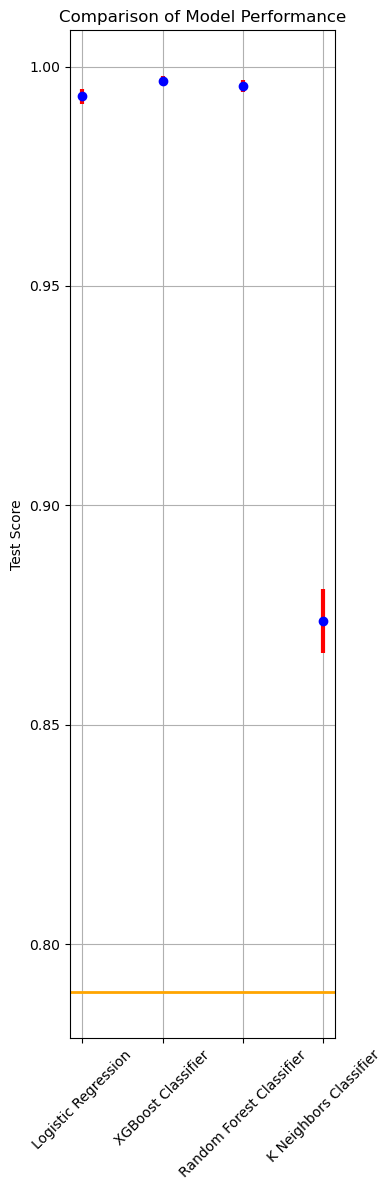

In [18]:
# Visualize Model Performances

plt.figure(figsize=(4,12))

# plot model performances (mean test score + standard deviation)
for i in range(len(model_performances_df)):
    plt.errorbar(i, model_performances_df['Mean Test Score'][i], yerr=model_performances_df['Std Test Score'][i], fmt='o', color='b',
                 ecolor='r', elinewidth=3, capsize=0)

# Add a line for baseline accuracy
plt.axhline(y=0.78896, color='orange', linestyle='-', linewidth=2, label='Baseline Accuracy')

# Customize the plot with labels, title, and grid
plt.xticks(range(len(model_performances_df)), model_performances_df['Model'])
plt.xticks(rotation=45)
plt.title('Comparison of Model Performance')
plt.ylabel('Test Score')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


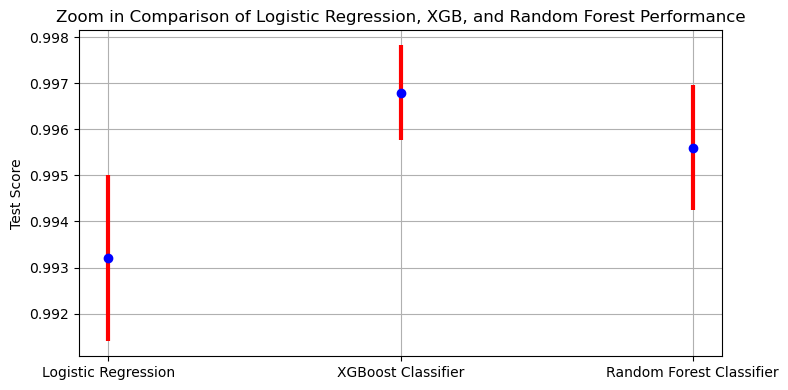

In [19]:
# Zoom in on Logistic Regression, XGB, Random Forest

plt.figure(figsize=(8,4))

model_performance_no_knn = model_performances_df.iloc[:3]

# plot model performances (mean test score + standard deviation)
for i in range(len(model_performance_no_knn)):
    plt.errorbar(i, model_performance_no_knn['Mean Test Score'][i], yerr=model_performance_no_knn['Std Test Score'][i], fmt='o', color='b',
                 ecolor='r', elinewidth=3, capsize=0)

# Add a line for baseline accuracy
#plt.axhline(y=0.78896, color='orange', linestyle='-', linewidth=2, label='Baseline Accuracy')

# Customize the plot with labels, title, and grid
plt.xticks(range(len(model_performance_no_knn)), model_performance_no_knn['Model'])
plt.title('Zoom in Comparison of Logistic Regression, XGB, and Random Forest Performance')
plt.ylabel('Test Score')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [29]:
def model_comparison(model_results):
    mean_test_scores = []
    [mean_test_scores.append(result['mean_test_score']) for result in model_results]
    row_wise_averages = [sum(row) / len(row) for row in zip(*mean_test_scores)]
    return row_wise_averages

In [30]:
model_performances_box_plot = []
model_performances_box_plot.append({
        'Model': 'Logistic Regression',
        'Mean Test Score': model_comparison(LR_results)
    })
model_performances_box_plot.append({
        'Model': 'XGBoost Classifier',
        'Mean Test Score': model_comparison(XGB_results)
    })
model_performances_box_plot.append({
        'Model': 'Random Forest Classifier',
        'Mean Test Score': model_comparison(RF_results)
    })
model_performances_box_plot.append({
        'Model': 'KNN Classifier',
        'Mean Test Score': model_comparison(KNN_results)
    })

pd.DataFrame(model_performances_box_plot)

,Model,Mean Test Score
0,Logistic Regression,"[0.8765617191404299, 0.9419623521572547, 0.977..."
1,XGBoost Classifier,"[0.9951357654506081, 0.9946360153256704, 0.994..."
2,Random Forest Classifier,"[0.7891054472763618, 0.7891054472763618, 0.849..."
3,KNN Classifier,"[0.8676661669165417, 0.8681326003664834, 0.868..."


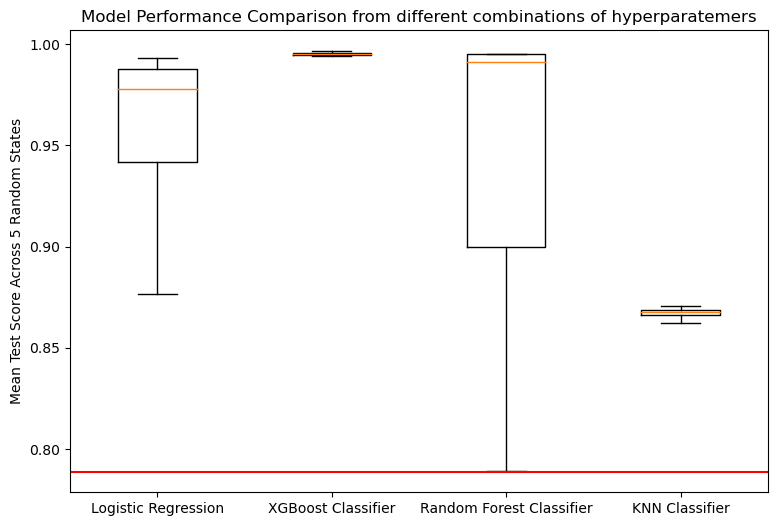

In [31]:
# Averaging mean_test_score of all fits across 5 random states
model_performances_box_plot_df = pd.DataFrame(model_performances_box_plot)

boxplot_data = [scores for scores in model_performances_box_plot_df['Mean Test Score']]

plt.figure(figsize=(9, 6))
plt.boxplot(boxplot_data, labels=model_performances_box_plot_df['Model'])
plt.axhline(y=0.78896, color='red', linestyle='-', linewidth=1.5, label='Baseline Accuracy')
plt.title('Model Performance Comparison from different combinations of hyperparatemers')
plt.ylabel('Mean Test Score Across 5 Random States')
plt.show()

## 7. Finalizing Model

**7.1 Predict on Test Set Using Best Model**

As seen above, our best model is a XGBoost Classifier with colsample_bytree=0.9, subsample=0.8, max_depth=20,reg_alpha=0.1, reg_lambda=1.0. Training on a subsample of 10w datapoints across 5 different random states yield a mean accuracy of 0.9968 with standard deviation 0.001030.

We will now split and preprocess our full dataset, fit using our best model, and predict on our test set.

In [20]:
# prepare dataset for final selected model

X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.01, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_other, y_other, test_size=1/99, random_state=42, stratify=y_other)

# fit_transform the training set
X_train_prep = preprocessor.fit_transform(X_train)

# transform the validation set
X_val_prep = preprocessor.transform(X_val)

# transform the test set
X_test_prep = preprocessor.transform(X_test)

# feature names after endoring
feature_names = preprocessor.get_feature_names_out()

# store the prepared X_train_prep, X_val_prep and X_test_prep in df for future use
df_train = pd.DataFrame(data=X_train_prep,columns=feature_names)
print('training data dimensions: ', df_train.shape)

df_val = pd.DataFrame(data=X_val_prep,columns=feature_names)
print('validation data dimensions: ', df_val.shape)

df_test = pd.DataFrame(data=X_test_prep,columns = feature_names)
print('testing data dimensions: ',df_test.shape)
print('')
print(f"y_train_prep Distribution: Fully-Paid: {100-y_train.mean() * 100:.2f}%, Defaulted/Charged-off: {y_train.mean() * 100:.2f}%")
print(f"y_val_prep Distribution: Fully-Paid: {100-y_val.mean() * 100:.2f}%, Defaulted/Charged-off: {y_val.mean() * 100:.2f}%")
print(f"y_test_prep Distribution: Fully-Paid: {100-y_test.mean() * 100:.2f}%, Defaulted/Charged-off: {y_test.mean() * 100:.2f}%")
print('\n\n feature names after encoding/preprocessing: ',feature_names)

training data dimensions:  (724603, 103)
validation data dimensions:  (7394, 103)
testing data dimensions:  (7394, 103)

y_train_prep Distribution: Fully-Paid: 78.90%, Defaulted/Charged-off: 21.10%
y_val_prep Distribution: Fully-Paid: 78.90%, Defaulted/Charged-off: 21.10%
y_test_prep Distribution: Fully-Paid: 78.90%, Defaulted/Charged-off: 21.10%


 feature names after encoding/preprocessing:  ['std__term' 'std__dti' 'std__earliest_cr_line' 'std__open_acc'
 'std__pub_rec' 'std__revol_util' 'std__total_pymnt' 'std__total_rec_int'
 'std__last_pymnt_amnt' 'std__acc_open_past_24mths' 'std__avg_cur_bal'
 'std__bc_open_to_buy' 'std__bc_util' 'std__mo_sin_old_rev_tl_op'
 'std__mo_sin_rcnt_rev_tl_op' 'std__mort_acc' 'std__num_actv_rev_tl'
 'std__pub_rec_bankruptcies' 'std__log_annual_inc' 'minmax__loan_amnt'
 'minmax__int_rate' 'minmax__installment' 'minmax__fico_score'
 'cat__home_ownership_ANY' 'cat__home_ownership_MORTGAGE'
 'cat__home_ownership_NONE' 'cat__home_ownership_OTHER'
 'cat__home

In [21]:
# Initialize the model
model = XGBClassifier(random_state=42, colsample_bytree=0.9, subsample=0.8, max_depth=20,reg_alpha=0.1, reg_lambda=1.0)

# Fit the model
model.fit(df_train, y_train, eval_set=[(df_val, y_val)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

Validation accuracy: 0.998241817690019
Validation precision: 0.9993544222078761
Validation recall: 0.9923076923076923
Validation F1 score: 0.9958185911868769

Test accuracy: 0.9972951041384907
Test precision: 0.9993514915693904
Test recall: 0.9878205128205129
Test F1 score: 0.9935525467440361


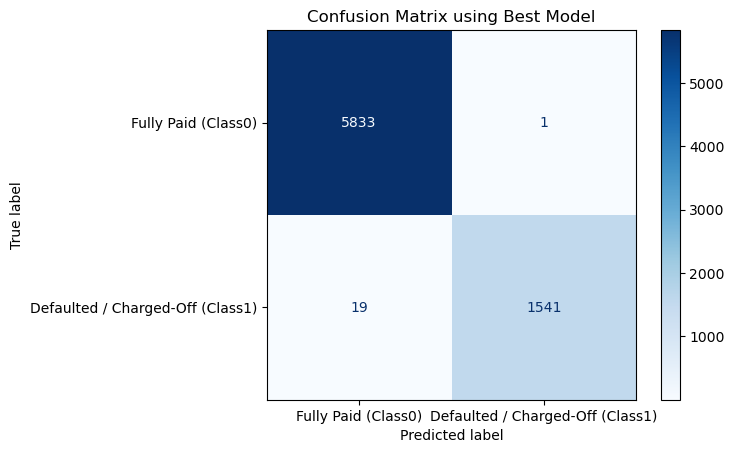

In [35]:
threshold = 0.2

# Predict on validation set
y_val_prob = model.predict_proba(df_val)[:, 1]
y_val_pred = (y_val_prob >= threshold).astype(int)

print('Validation accuracy:', accuracy_score(y_val, y_val_pred))
print('Validation precision:', precision_score(y_val, y_val_pred))
print('Validation recall:', recall_score(y_val, y_val_pred))
print('Validation F1 score:', f1_score(y_val, y_val_pred))
print('')

# Predict on test set
y_test_prob = model.predict_proba(df_test)[:, 1]
y_test_pred = (y_test_prob >= threshold).astype(int)

print('Test accuracy:', accuracy_score(y_test, y_test_pred))
print('Test precision:', precision_score(y_test, y_test_pred))
print('Test recall:', recall_score(y_test, y_test_pred))
print('Test F1 score:', f1_score(y_test, y_test_pred))

cm = confusion_matrix(y_test,y_test_pred)
labels = ['Fully Paid (Class0)', 'Defaulted / Charged-Off (Class1)']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix using Best Model')
plt.show()

**7.2 Feature Selection**

In [34]:
df_train

,std__term,std__dti,std__earliest_cr_line,std__open_acc,std__pub_rec,std__revol_util,std__total_pymnt,std__total_rec_int,std__last_pymnt_amnt,std__acc_open_past_24mths,...,cat__addr_state_WA,cat__addr_state_WI,cat__addr_state_WV,cat__addr_state_WY,cat__initial_list_status_f,cat__initial_list_status_w,cat__application_type_Individual,cat__application_type_Joint App,ord__grade,ord__sub_grade
0,1.769085,-0.141290,-0.306125,0.236617,-0.363290,0.604532,3.413711,4.959506,1.487401,-1.500147,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,16.0
1,-0.565264,-1.141690,0.366962,-0.136125,-0.363290,1.084804,1.177018,0.070842,-0.149812,-0.235787,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,-0.565264,-0.496739,1.578517,0.422989,-0.363290,0.700586,-0.331761,-0.431603,-0.203216,0.080303,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,6.0
3,-0.565264,-0.021689,-0.575359,-0.508867,1.288024,0.495948,-0.403617,-0.685678,0.397872,0.080303,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,14.0
4,-0.565264,0.966416,0.770813,-0.322496,-0.363290,-0.865519,-1.303740,-0.933292,-0.648027,0.080303,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724598,-0.565264,0.584140,1.040048,-0.322496,-0.363290,1.105685,-1.416989,-0.911596,-0.827650,1.344663,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,12.0
724599,-0.565264,1.292803,-0.171507,0.050246,-0.363290,-0.134670,1.085211,1.779056,-0.726058,1.344663,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,18.0
724600,-0.565264,1.106136,0.232344,1.354845,-0.363290,0.671352,2.201865,-0.245822,3.648523,-0.551877,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,10.0
724601,-0.565264,-0.239653,1.040048,0.982102,-0.363290,0.069968,-0.762890,-0.745293,-0.054661,-0.235787,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,13.0


In [35]:
nr_runs = 10
scores = np.zeros([len(feature_names),nr_runs])

test_score = model.score(df_test,y_test)
print('test score = ',test_score)
print('test baseline = ', baseline_accuracy) # all guessing majority class
# loop through the features
for i in range(len(feature_names)):
    print('shuffling '+str(feature_names[i]))
    acc_scores = [] # shuffled score
    for j in range(nr_runs):
        X_test_shuffled = df_test.copy()
        X_test_shuffled[feature_names[i]] = np.random.permutation(df_test[feature_names[i]].values)
        acc_scores.append(model.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.9970246145523397
test baseline =  0.78896416104605
shuffling std__term
   shuffled test score: 0.992 +/- 0.001
shuffling std__dti
   shuffled test score: 0.997 +/- 0.0
shuffling std__earliest_cr_line
   shuffled test score: 0.997 +/- 0.0
shuffling std__open_acc
   shuffled test score: 0.997 +/- 0.0
shuffling std__pub_rec
   shuffled test score: 0.997 +/- 0.0
shuffling std__revol_util
   shuffled test score: 0.997 +/- 0.0
shuffling std__total_pymnt
   shuffled test score: 0.594 +/- 0.002
shuffling std__total_rec_int
   shuffled test score: 0.974 +/- 0.001
shuffling std__last_pymnt_amnt
   shuffled test score: 0.962 +/- 0.002
shuffling std__acc_open_past_24mths
   shuffled test score: 0.997 +/- 0.0
shuffling std__avg_cur_bal
   shuffled test score: 0.997 +/- 0.0
shuffling std__bc_open_to_buy
   shuffled test score: 0.997 +/- 0.0
shuffling std__bc_util
   shuffled test score: 0.997 +/- 0.0
shuffling std__mo_sin_old_rev_tl_op
   shuffled test score: 0.997 +/- 0.0
shuffling 

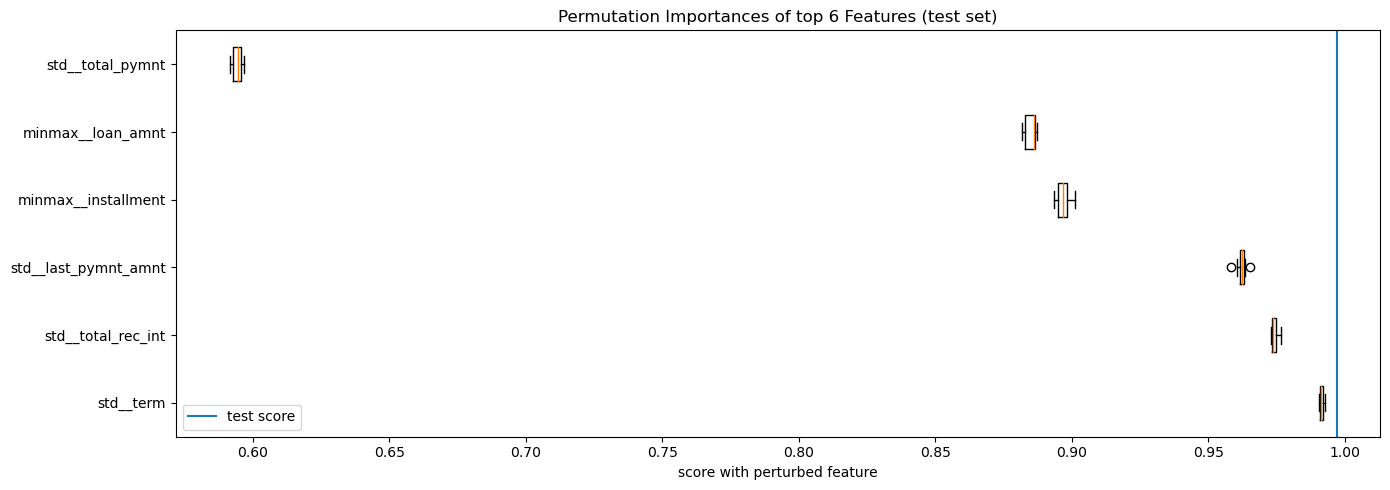

In [36]:
abs_diff_from_test = np.abs(np.mean(scores,axis=1) - test_score)
sorted_indices = np.argsort(abs_diff_from_test)[::-1]
top_6_ftrs_idx = sorted_indices[:6][::-1]

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(14,5))
plt.boxplot(scores[top_6_ftrs_idx].T,labels=feature_names[top_6_ftrs_idx],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances of top 6 Features (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()

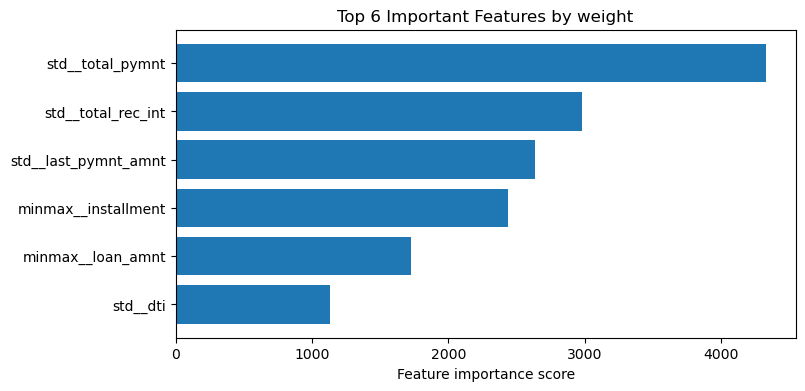

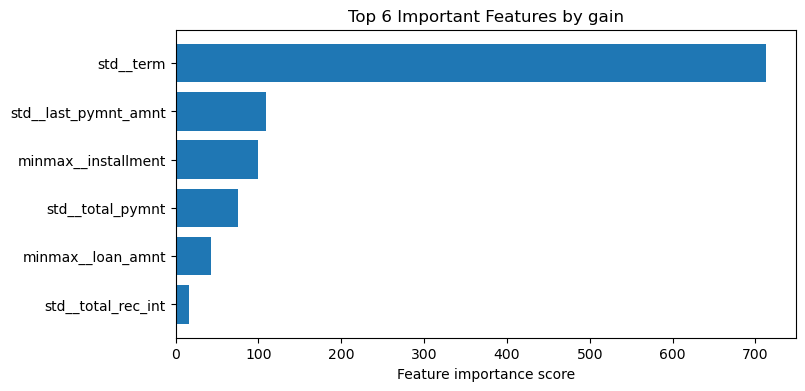

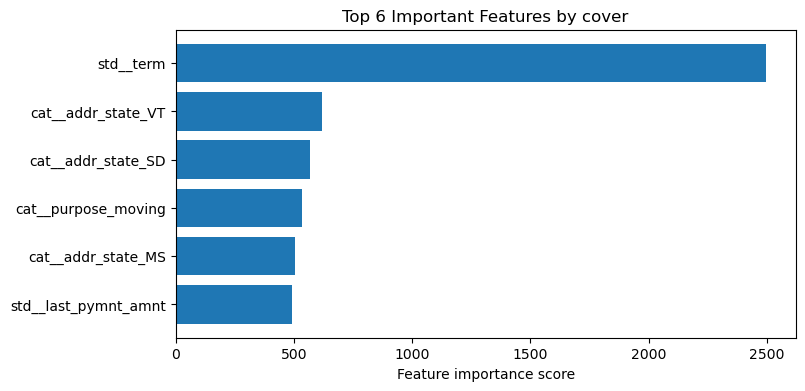

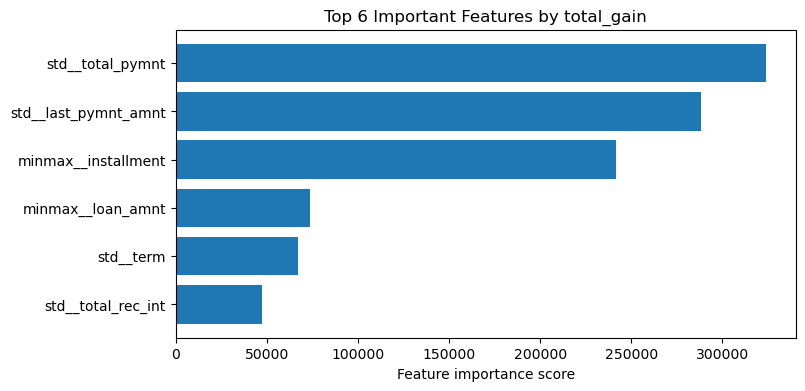

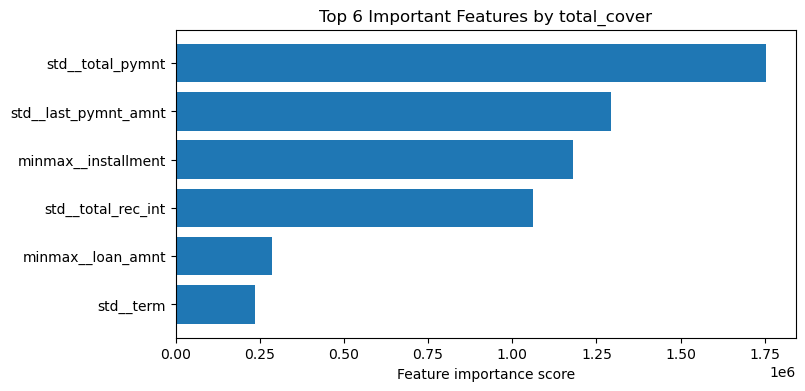

In [37]:
def plot_feature_importance(importance_type):
    scores_dict = model.get_booster().get_score(importance_type=importance_type)
    ftr_names = np.array(list(scores_dict.keys()))
    scores = np.array(list(scores_dict.values()))

    sorted_indices = np.argsort(scores)[::-1]
    top_6_indices = sorted_indices[:6]

    plt.figure(figsize=(8,4))
    plt.barh(range(6), scores[top_6_indices], align='center')
    plt.yticks(range(6), ftr_names[top_6_indices])
    plt.gca().invert_yaxis()
    plt.xlabel('Feature importance score')
    plt.title(f'Top 6 Important Features by {importance_type}')
    plt.show()

# 1. Weight
plot_feature_importance('weight')

# 2. Gain
plot_feature_importance('gain')

# 3. Cover
plot_feature_importance('cover')

# 4. Total Gain
plot_feature_importance('total_gain')

# 5. Total Cover
plot_feature_importance('total_cover')


In [38]:
import shap
shap.initjs() # required for visualizations later on

# create the explainer object with the random forest model
explainer = shap.TreeExplainer(model)

# transformed test set
print(np.shape(df_test))

# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(df_test[:1000]) # -- computationally expensive
print(np.shape(shap_values))


(7394, 103)
(1000, 103)


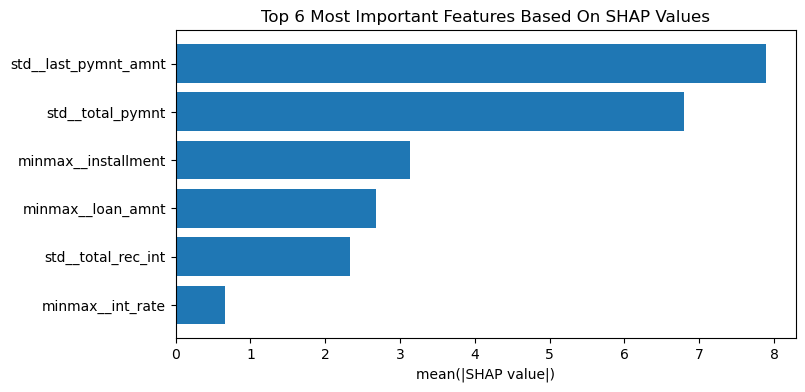

In [39]:
shap_summary = np.abs(shap_values[1]) + np.abs(shap_values[0]) # same shape as the number of features
indcs = np.argsort(shap_summary)
shap_summary[indcs]

plt.figure(figsize=(8,4))
plt.barh(feature_names[indcs[-6:]],shap_summary[indcs[-6:]])
plt.xlabel('mean(|SHAP value|)')
plt.title('Top 6 Most Important Features Based On SHAP Values')
plt.show()

In [40]:
index = 0
shap.force_plot(explainer.expected_value, shap_values[index,:], features = df_test.iloc[index,:], feature_names = feature_names)

In [41]:
index = 100
shap.force_plot(explainer.expected_value, shap_values[index,:], features = df_test.iloc[index,:], feature_names = feature_names)

In [42]:
index = 620
shap.force_plot(explainer.expected_value, shap_values[index,:], features = df_test.iloc[index,:], feature_names = feature_names)